In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.dirname('__file__')))
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.2"
os.environ['R_LANGUAGE'] = 'en_US.UTF-8'
os.environ["PYTHONIOENCODING"] = "utf-8"
os.environ["R_DEFAULT_ENCODING"] = "utf-8"

In [67]:
#!pip install -q -r Requirements.txt

In [68]:
#!pip install --upgrade yfinance pandas_datareader requests

In [2]:
%%capture
"""
Al imports needed for this notebook
"""
#from model.names import IndexMeta as im
#from model.names import IndexMeta
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
from pathlib import Path
import yfinance as yf
from datetime import datetime, timedelta
import json
"""
    +----------------+
    | test libraries |
    +----------------+
"""
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy.stats import shapiro, normaltest, jarque_bera
import scipy.stats as stats
import statsmodels.api as sma
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
"""
    +------------------+
    | graphics library |
    +------------------+
"""
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

import os
#from controller.injector import Injector
#from model.index import Index
import matplotlib.pyplot as plt
import json

"""
    +------------+
    | R packages |
    +------------+
"""
import rpy2.robjects.packages as rpackages
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

In [3]:
"""
    +-----------------+
    | Config defaults |
    +-----------------+
"""

class Config:
    LOOKUP_DAYS = 'lookup_days'
    END_DATE = 'end_date'
    DATE_FORMAT = 'date_format'
    INDEXES = 'indexes'
    LOCAL_CACHE = 'local_cache'

"""
    +-------------------+
    | Metadata defaults |
    +-------------------+
"""
class IndexMeta:
    INDEX = 'index'
    DATE = 'Date'
    ADJ_CLOSE = 'Adj Close'
    ADJUSTED_CLOSE = 'Adjusted Close'
    LOG_RETURN = 'Log Return'
    LOG_RETURN_PERCENTAGE = 'Log Return Percentage'
    ABSOLUTE_RETURN = 'Absolute Return'
    SQUARED_RETURN = 'Squared Return'
    __ACF = 'ACF'
    ACF_LOG_RET = f'{__ACF} {LOG_RETURN}'
    ACF_ABS_RET = f'{__ACF} {ABSOLUTE_RETURN}'
    ACF_SQRT_RET = f'{__ACF} {SQUARED_RETURN}'
    REALIZED_VOLATILITY = 'Realized Volatility'
    ANNUALIZED_REALIZED_VOLATILITY = f'Annualized {REALIZED_VOLATILITY}'
    VOLATILITY_EWM = 'Volatility Ewm'
    ANNUALIZED_VOLATILITY_EWM = f'Annualized {VOLATILITY_EWM}'
    GARCH_RESIDUALS = 'Garch Residuals'
    GARCH_FORECAST_SERIES = 'Forecast Series'
    GARCH_FORECAST_SIGMA = 'Forecast Sigma'
    GARCH_CONDITIONAL_VOLATILITY = 'Garch Conditional Volatility'
    

    
"""
    +--------------+
    | Index Entity |
    +--------------+
"""
    
class Index:

    def __init__(self, index_name: str, index_ticker: str, data: pd.DataFrame):
        """

        :param index_name:
        :param index_ticker:
        :param data:
        :see da
        """
        self.i_name = index_name
        self.i_ticker = index_ticker
        self.df = data
        self.daily_info: pd.DataFrame = pd.DataFrame()
        self.realized_volatility: pd.DataFrame = pd.DataFrame()
        self.volatility_ewm: pd.DataFrame = pd.DataFrame()
        self.monthly_info: pd.DataFrame = pd.DataFrame()
        self.acf_log: pd.DataFrame = pd.DataFrame()
        self.acf_abs: pd.DataFrame = pd.DataFrame()
        self.acf_sqrt: pd.DataFrame = pd.DataFrame()
        self.residuals: pd.DataFrame = pd.DataFrame()
        self.forecast: pd.DataFrame = pd.DataFrame()
        self.model: str = ""

    def __str__(self):
        return f'{{name: {self.i_name}, ticker: {self.i_ticker}, data_size:{self.df.size}}}'

    def __repr__(self):
        return self.__str__()

    def get_df_by_name(self, col_name=IndexMeta.ADJUSTED_CLOSE) -> pd.DataFrame | None:

        if col_name in self.df.columns:
            return self.df[col_name]
        elif col_name in self.daily_info.columns:
            return self.daily_info[col_name]
        elif col_name in self.volatility_ewm.columns:
            return self.volatility_ewm[col_name]
        elif col_name in self.residuals.columns: 
            return self.residuals[col_name]
        elif col_name in self.realized_volatility:
            return self.realized_volatility[col_name]
        return None

    
"""
    +------------------------------+
    | Injecting data From yfinance |
    +------------------------------+
"""

class Injector:
    __DEFAULT_YEARS = 2
    __DEFAULT_LOOKUPS = __DEFAULT_YEARS * 365
    __DEFAULT_END = datetime.today()
    __DEFAULT_DATE_FORMAT = '%Y-%m-%d'
    __LINES = '-----------------------------------------------------------'

    def __init__(self, conf_file: str):
        self.indexes: list[Index] = []
        self.__inject_data_from_yahoo(conf_file)
        self.__setup_daily_data()
        self.__setup_monthly_data()
        self.__setup_relized_volatility()
        self.__setup_volatility_ewm()
        self.__setup_index()
        pass

    def __inject_data_from_yahoo(self, conf_file):

        try:
            with open(conf_file, 'r', encoding='utf-8') as file_conf:
                config = json.load(file_conf)
                print(config)
                lookup_days = config.get(Config.LOOKUP_DAYS, Injector.__DEFAULT_LOOKUPS)
                end_date = config.get(Config.END_DATE, Injector.__DEFAULT_END)
                date_format = config.get(Config.DATE_FORMAT, Injector.__DEFAULT_DATE_FORMAT)
                start_date = (end_date - timedelta(days=lookup_days)).strftime(date_format)
                end_date = end_date.strftime(date_format)
                index_list = config.get(Config.INDEXES, None)
                for index in index_list:
                    from_yahoo = yf.download(
                        index_list[index],
                        start=start_date,
                        end=end_date,
                        auto_adjust=False
                    )
                    from_yahoo = pd.DataFrame({key[0]: value for key, value in from_yahoo.items()})
                    from_yahoo.reset_index(inplace=True)
                    from_yahoo.rename(columns={IndexMeta.INDEX: IndexMeta.DATE}, inplace=True)
                    from_yahoo.rename(columns={IndexMeta.ADJ_CLOSE: IndexMeta.ADJUSTED_CLOSE}, inplace=True)
                    from_yahoo[IndexMeta.DATE] = from_yahoo[IndexMeta.DATE].dt.date
                    index_bean = Index(index_name=index,
                                       index_ticker=index_list[index],
                                       data=from_yahoo)
                    print(index_bean.df.columns)
                    self.indexes.append(index_bean)

        except FileNotFoundError:
            print(f"file {file_conf} not found")
            exit(-1)
        except json.JSONDecodeError:
            print("Error in decoding json")
            exit(-1)
        except AttributeError:
            print("some attribute is None")
            exit(-1)

    def __setup_daily_data(self):

        for index in self.indexes:
            index.daily_info = pd.DataFrame(index.df[IndexMeta.DATE])

            index.daily_info[IndexMeta.LOG_RETURN] = np.log(
                index.df[IndexMeta.ADJUSTED_CLOSE] / index.df[IndexMeta.ADJUSTED_CLOSE].shift(1)
            )

            index.daily_info[IndexMeta.ABSOLUTE_RETURN] = index.df[IndexMeta.ADJUSTED_CLOSE].pct_change().abs()
            index.daily_info[IndexMeta.SQUARED_RETURN] = np.square(index.df[IndexMeta.ADJUSTED_CLOSE].pct_change())
            index.daily_info.set_index(IndexMeta.DATE, inplace=True)
            index.daily_info.index = pd.to_datetime(index.daily_info.index)
            index.daily_info.dropna(inplace=True)
            index.daily_info[IndexMeta.LOG_RETURN_PERCENTAGE] = index.daily_info[IndexMeta.LOG_RETURN] * 100

            # ACF for log return
            acf_values = sma.tsa.acf(index.daily_info[IndexMeta.LOG_RETURN], nlags=30)
            index.acf_log = pd.DataFrame({
                IndexMeta.ACF_LOG_RET: acf_values
            }, index=range(len(acf_values)))

            # ACF for absolute return
            acf_values = sma.tsa.acf(index.daily_info[IndexMeta.ABSOLUTE_RETURN], nlags=30)
            index.acf_abs = pd.DataFrame({
                IndexMeta.ACF_ABS_RET: acf_values
            }, index=range(len(acf_values)))
            # ACF for squared return
            acf_values = sma.tsa.acf(index.daily_info[IndexMeta.SQUARED_RETURN], nlags=30)
            index.acf_sqrt = pd.DataFrame({
                IndexMeta.ACF_SQRT_RET: acf_values
            }, index=range(len(acf_values)))

    def __setup_monthly_data(self):
        for index in self.indexes:
            dummy = pd.DataFrame(index.daily_info)
            dummy = dummy[dummy.index.is_month_end]
            index.monthly_info = dummy

        pass
    
    def __setup_relized_volatility(self, window=21):
        
        for index in self.indexes: 
            df = index.daily_info.copy()
            df[IndexMeta.REALIZED_VOLATILITY] = (df[IndexMeta.LOG_RETURN_PERCENTAGE].rolling(window=window).std()).dropna()
            df[IndexMeta.ANNUALIZED_REALIZED_VOLATILITY] = df[IndexMeta.REALIZED_VOLATILITY] * np.sqrt(252)
            #df.dropna(inplace=True)
            index.realized_volatility = df

    def __setup_volatility_ewm(self, lam=0.90) -> None:
        """
        :param lam: indicate the effort for older data
        """
        for index in self.indexes:
            dummy = pd.DataFrame(index.daily_info[[IndexMeta.LOG_RETURN_PERCENTAGE]])
            dummy_ewm = np.sqrt(dummy.ewm(span=1 / (1 - lam)).var())
            index.volatility_ewm = dummy_ewm
            index.volatility_ewm.columns = [IndexMeta.VOLATILITY_EWM]
            index.volatility_ewm[IndexMeta.ANNUALIZED_VOLATILITY_EWM] = (index.volatility_ewm[IndexMeta.VOLATILITY_EWM]
                                                                     * np.sqrt(252))

    def print_indexes(self):
        print(Injector.__LINES)
        print("Analyzing this index list: {")
        for index in self.indexes:
            print(f'\t{index}')
        print(f'}}\n{Injector.__LINES}')

    def get_multi_index(self) -> pd.DataFrame:
        ret: pd.DataFrame
        concat = []
        columns = []
        for index in self.indexes:
            concat.append(index.daily_info[IndexMeta.LOG_RETURN_PERCENTAGE])
            columns.append(index.i_name)
        ret = pd.concat(concat, axis=1)
        ret.columns = columns
        ret.dropna(inplace=True)
        return ret

    def local_cache(self):
        for index in self.indexes:
            index.df.to_csv(f"{Config.LOCAL_CACHE}{os.sep}{index.i_name.split(' ')[0]}#{index.i_ticker}.csv")

    def __setup_index(self):
        for index in self.indexes:
            index.df.set_index('Date', inplace=True)

    def get_indexes_names(self) -> list[str]:
        ret = []
        for index in self.indexes:
            ret.append(index.i_name)
        return ret
    

            
              

In [71]:
%%capture
if not rpackages.isinstalled('rugarch') or not rpackages.isinstalled('rmgarch'):
    raise RuntimeError('rugarch missing')

injector = Injector(conf_file=f'{os.getcwd()}{os.sep}config{os.sep}config.json')

In [72]:
injector.local_cache()

In [73]:
"""
    +--------------------------+
    | Printers Plot and Tables |
    +--------------------------+
"""

class PlotColors:
    
    def __init__(self):
        raise NotImplemented('Cannot instantiate the class')
        
    __DEFAUL_COLORS = {
        "Blue": "#1976D2",
        "Red": "#D32F2F",
        "Green": "#388E3C",
        "Yellow": "#FBC02D",
        "Orange": "#E64A19",
        "Purple": "#7B1FA2",
        "Teal": "#00796B",
        "Pink": "#C2185B",
        "Turquoise": "#0097A7",
        "Gray": "#616161",
        "Brown": "#795548",
        "Cyan": "#00ACC1",
        "Lime": "#7CB342",
        "Magenta": "#D81B60",
        "Indigo": "#303F9F",
        "Gold": "#FFA000",
        "Crimson": "#C62828",
        "Olive": "#558B2F",
        "Navy": "#283593",
        "Amber": "#FF8F00",
        "Mint": "#4DB6AC"
    }
    
    @staticmethod
    def get_color(name='Blue'):
        return PlotColors.__DEFAUL_COLORS[name]
    
    @staticmethod
    def get_color_dict():
        return PlotColors.__DEFAUL_COLORS.copy()
    
    @staticmethod
    def get_color_list():
        color_list = []
        for (_, color) in PlotColors.__DEFAUL_COLORS.items():
            color_list.append(color)
        return color_list


def get_df_to_show(name, injector) -> pd.DataFrame():
    for index in injector.indexes:
        if index.i_name == name:
            return index.df
    return pd.DataFrame({})

def plot_adj_close(name, injector):
    plt.figure(figsize=(12, 6))
    df = get_df_to_show(name, injector)
    plt.plot(df.index, df[im.ADJUSTED_CLOSE])
    plt.show()


sns.set_theme(style="whitegrid")

def multi_plot_in_row(dfs: list[pd.DataFrame], info=IndexMeta.LOG_RETURN_PERCENTAGE,
                      fig_size=(20, 40), plot_names=None):
    if plot_names is None:
        plot_names = ["plot"]
    fig, axs = plt.subplots(len(dfs), 1, figsize=fig_size, gridspec_kw={'hspace': 0.75})
    i = 0
    for df in dfs:
        sns.lineplot(x=df.index, y=df[info], ax=axs[i], color='#2980b9')
        axs[i].set_title(f'{plot_names[i%len(plot_names)]} {info}')
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
        i+=1
    plt.show()


def print_res_test(data, test='adf') -> pd.DataFrame:
    ret = {}
    for index in data:
        ret[index] = {"Statistic": data[index][test][0] , 'PVALUE' : data[index][test][1], 'Null Hypotesis': data[index]['outcome']}
    return pd.DataFrame(ret)

In [4]:
from IPython.core.display import HTML

# Definire il CSS come stringa
css = """
    <style>
    /* Corpo della pagina */
    body {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background-color: #f7f9fc;
        color: #2c3e50;
        margin: 0;
        padding: 0;
        line-height: 1.6;
    }

    /* Contenitore principale */
    .container {
        width: 80%;
        margin: 0 auto;
        padding: 40px;
    }

    /* Titoli */
    h1 {
        font-size: 40px;
        text-align: center;
        color: #2980b9;
        margin-bottom: 20px;
    }

    h2 {
        font-size: 30px;
        color: #2980b9;
        margin-top: 40px;
        border-bottom: 2px solid #2980b9;
        padding-bottom: 10px;
    }

    h3 {
        font-size: 24px;
        color: #34495e;
        margin-top: 20px;
    }

    /* Paragrafi */
    p {
        font-size: 18px;
        color: #34495e;
        margin-bottom: 20px;
    }

    /* Liste */
    ul {
        list-style-type: square;
        margin-left: 30px;
        margin-bottom: 20px;
    }

    li {
        font-size: 18px;
        color: #34495e;
    }

    /* Evidenziazione */
    .highlight {
        color: #e74c3c;
        font-weight: bold;
    }

    /* Sezioni */
    .section {
        margin-bottom: 40px;
    }

    .content {
        background-color: #ffffff;
        padding: 30px;
        border-radius: 8px;
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        margin-top: 20px;
    }

    /* Link */
    a {
        color: #2980b9;
        text-decoration: none;
        font-weight: bold;
    }

    a:hover {
        text-decoration: underline;
    }

    /* Footer */
    footer {
        text-align: center;
        padding: 20px;
        background-color: #2c3e50;
        color: white;
        font-size: 16px;
        margin-top: 40px;
    }
    /* Stile della tabella */
    .styled-table {
        width: 70%;
        margin: 20px auto;
        border-collapse: collapse;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background-color: #ffffff;
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        border-radius: 8px;
        border: 2px solid #2c3e50;  /* Bordo esterno più marcato */
    }

    /* Stile delle celle */
    .styled-table th, .styled-table td {
        border: 2px solid #2c3e50; /* Bordi più visibili */
        padding: 12px;
        text-align: center;
        font-size: 18px;
    }

    /* Colore intestazioni */
    .styled-table th {
        background-color: #2980b9;
        color: white;
        font-size: 20px;
        border: 2px solid #2c3e50;
    }

    /* Colore righe alternate */
    .styled-table tr:nth-child(even) {
        background-color: #f2f2f2;
    }

    /* Hover effetto */
    .styled-table tr:hover {
        background-color: #dfe6e9;
    }

    .styled-table-2 {
        width: 30%;
        height: 30%;
        margin: 20px auto;
        border-collapse: collapse;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background-color: #ffffff;
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        border-radius: 8px;
        border: 2px solid #2c3e50;  /* Bordo esterno più marcato */
    }

    /* Stile delle celle */
    .styled-table-2 th, .styled-table-2 td {
        border: 2px solid #2c3e50; /* Bordi più visibili */
        padding: 12px;
        text-align: center;
        font-size: 14px;
    }

    /* Colore intestazioni */
    .styled-table-2 th {
        background-color: #2980b9;
        color: white;
        font-size: 16px;
        border: 2px solid #2c3e50;
    }

    /* Colore righe alternate */
    .styled-table-2 tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    
</style>


"""

# Visualizzare il CSS
HTML(css)


In [75]:
paragraph_1 = """<h1>Progetto di Metodi Probabilistici e Statistici per Mercati Finanziari</h1>
<h2>Autore: Dissan Uddin Ahmed</h2>

<div >
    <h2>Analisi Finanziaria Dei Mercati Nazionali</h2>
    <p>I mercati finanziari nazionali rappresentano un pilastro fondamentale dell’economia globale, riflettendo le dinamiche economiche, politiche e sociali di ciascun paese. Questo tipo di analisi aiuta gli investitori a gestire il rischio e capire quali titoli inserire nel proprio portafoglio finanziario. Si cerca di capire come la volatilità sia un parametro da tenere d'occhio quando si investe in borsa.</p>

    <div class="section">
        <h3>1) Analisi di mercato</h3>
        <p>La liquidità di un mercato finanziario si riferisce alla facilità con cui gli investitori possono comprare o vendere titoli finanziari senza causare significative fluttuazioni nei prezzi di mercato. Un mercato altamente liquido è caratterizzato da una maggiore attività di scambio di titoli, un elevato numero di partecipanti, un elevato volume di scambi giornalieri e una stretta differenza tra i prezzi di acquisto (offerta) e i prezzi di vendita (domanda), noti come spread.</p>
        <p>La liquidità è un importante fattore da considerare quando si decide di investire in un mercato finanziario.</p>
    </div>

    <div class="section">
        <h3>1.1) Entrata e Uscita mercato azionario</h3>
        <p>L'entrata e l'uscita dal mercato finanziario sono processi fondamentali per investitori e aziende. Un investitore entra nel mercato acquistando strumenti finanziari come azioni, obbligazioni o derivati, generalmente tramite un intermediario finanziario come una banca o un broker. La decisione di investire si basa su analisi di mercato e strategie di rendimento.</p>
        <p>Le aziende possono entrare nel mercato attraverso la quotazione in borsa (IPO), e uscire quando decidono di vendere i propri asset o quando non rispettano i requisiti di mercato.</p>
    </div>

    <div class="section">
        <h3>1.2) Liquidità del Mercato Azionario</h3>
        <p>La liquidità del mercato azionario si riferisce alla facilità con cui le azioni possono essere acquistate o vendute senza causare fluttuazioni significative nel loro prezzo. Ci sono due aspetti principali della liquidità:</p>
        <ul>
            <li><b>Liquidità immediata:</b> La capacità di eseguire ordini di acquisto o vendita a un prezzo vicino al valore di mercato senza influenzare il prezzo stesso.</li>
            <li><b>Profondità del mercato:</b> La quantità di ordini di acquisto e vendita a vari livelli di prezzo.</li>
        </ul>
        <p>Fattori che influenzano la liquidità includono il volume di scambi, la volatilità e la partecipazione degli investitori istituzionali.</p>
    </div>

    <div >
        <h2>2) Estrazione dei dati</h2>
        <p>Sono stati scelti i mercati nazionali più importanti e il mercato nazionale italiano, un mercato più piccolo, per verificare alla fine dello studio, se c'è correlazione tra queste borse. I dati sono stati scaricati tramite la libreria Python <code>yfinance</code>, e comprendono la serie storica degli ultimi due anni degli indici delle seguenti borse:</p>
        <ol>
            <li>FTSE MIB</li>
            <li>Dow Jones</li>
            <li>NASDAQ</li>
            <li>Nikkei 225</li>
            <li>HANG SENG INDEX</li>
        </ol>
    </div>
    <p>In questa sezione si osservano i dataset che sono stati presi in considerazione ed i prezzi di chiusura rettificata delle varie borse.</p>
</div>
"""
HTML(paragraph_1)

### 2.1) FTSE MIB

In [76]:
display(Markdown(get_df_to_show('FTSE MIB', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-17</th>
      <td>38328.0</td>
      <td>38328.0</td>
      <td>38423.0</td>
      <td>37997.0</td>
      <td>37998.0</td>
      <td>802872800</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>38554.0</td>
      <td>38554.0</td>
      <td>38581.0</td>
      <td>38418.0</td>
      <td>38467.0</td>
      <td>686047400</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>38348.0</td>
      <td>38348.0</td>
      <td>38883.0</td>
      <td>38320.0</td>
      <td>38666.0</td>
      <td>924138500</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>38249.0</td>
      <td>38249.0</td>
      <td>38532.0</td>
      <td>38179.0</td>
      <td>38405.0</td>
      <td>471872000</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>38421.0</td>
      <td>38421.0</td>
      <td>38492.0</td>
      <td>38285.0</td>
      <td>38405.0</td>
      <td>463321500</td>
    </tr>
    <tr>
      <th>2025-02-24</th>
      <td>38473.0</td>
      <td>38473.0</td>
      <td>38594.0</td>
      <td>38155.0</td>
      <td>38433.0</td>
      <td>613633000</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>38715.0</td>
      <td>38715.0</td>
      <td>38910.0</td>
      <td>38303.0</td>
      <td>38323.0</td>
      <td>532235400</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>39225.0</td>
      <td>39225.0</td>
      <td>39252.0</td>
      <td>38798.0</td>
      <td>38826.0</td>
      <td>693421700</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>38623.0</td>
      <td>38623.0</td>
      <td>39046.0</td>
      <td>38380.0</td>
      <td>39044.0</td>
      <td>548304800</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>38655.0</td>
      <td>38655.0</td>
      <td>38691.0</td>
      <td>38324.0</td>
      <td>38415.0</td>
      <td>637789400</td>
    </tr>
  </tbody>
</table>

\[tabella 1\]

### 2.2) London Stock Exchange

In [77]:
display(Markdown(get_df_to_show('London Stock Exchange', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-17</th>
      <td>11725.0</td>
      <td>11725.0</td>
      <td>11765.0</td>
      <td>11632.200195</td>
      <td>11755.0</td>
      <td>407767</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>11690.0</td>
      <td>11690.0</td>
      <td>11755.0</td>
      <td>11647.916016</td>
      <td>11720.0</td>
      <td>581454</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>11705.0</td>
      <td>11705.0</td>
      <td>11795.0</td>
      <td>11625.000000</td>
      <td>11660.0</td>
      <td>1219294</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>11700.0</td>
      <td>11700.0</td>
      <td>11755.0</td>
      <td>11645.000000</td>
      <td>11755.0</td>
      <td>665478</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>11585.0</td>
      <td>11585.0</td>
      <td>11710.0</td>
      <td>11565.000000</td>
      <td>11685.0</td>
      <td>1810842</td>
    </tr>
    <tr>
      <th>2025-02-24</th>
      <td>11300.0</td>
      <td>11300.0</td>
      <td>11605.0</td>
      <td>11250.000000</td>
      <td>11560.0</td>
      <td>1012104</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>11140.0</td>
      <td>11140.0</td>
      <td>11330.0</td>
      <td>11110.000000</td>
      <td>11305.0</td>
      <td>1235707</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>11100.0</td>
      <td>11100.0</td>
      <td>11240.0</td>
      <td>11070.000000</td>
      <td>11145.0</td>
      <td>1891600</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>11775.0</td>
      <td>11775.0</td>
      <td>11805.0</td>
      <td>11190.000000</td>
      <td>11390.0</td>
      <td>1447385</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>11845.0</td>
      <td>11845.0</td>
      <td>11845.0</td>
      <td>11390.960938</td>
      <td>11795.0</td>
      <td>2581614</td>
    </tr>
  </tbody>
</table>

\[tabella 2\]

### 2.3) Dow Jones

In [78]:
display(Markdown(get_df_to_show('Dow Jones', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-14</th>
      <td>44546.078125</td>
      <td>44546.078125</td>
      <td>44769.050781</td>
      <td>44498.960938</td>
      <td>44720.988281</td>
      <td>474570000</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>44556.339844</td>
      <td>44556.339844</td>
      <td>44602.019531</td>
      <td>44319.320312</td>
      <td>44583.910156</td>
      <td>551790000</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>44627.589844</td>
      <td>44627.589844</td>
      <td>44636.191406</td>
      <td>44312.648438</td>
      <td>44478.121094</td>
      <td>438880000</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>44176.648438</td>
      <td>44176.648438</td>
      <td>44561.109375</td>
      <td>43950.160156</td>
      <td>44561.109375</td>
      <td>448500000</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>43428.019531</td>
      <td>43428.019531</td>
      <td>43959.730469</td>
      <td>43349.328125</td>
      <td>43820.128906</td>
      <td>622550000</td>
    </tr>
    <tr>
      <th>2025-02-24</th>
      <td>43461.210938</td>
      <td>43461.210938</td>
      <td>43699.148438</td>
      <td>43343.671875</td>
      <td>43493.121094</td>
      <td>615500000</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>43621.160156</td>
      <td>43621.160156</td>
      <td>43767.738281</td>
      <td>43282.980469</td>
      <td>43509.738281</td>
      <td>641310000</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>43433.121094</td>
      <td>43433.121094</td>
      <td>43866.500000</td>
      <td>43318.929688</td>
      <td>43635.421875</td>
      <td>590270000</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>43239.500000</td>
      <td>43239.500000</td>
      <td>43884.191406</td>
      <td>43224.531250</td>
      <td>43516.441406</td>
      <td>739620000</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>43840.910156</td>
      <td>43840.910156</td>
      <td>43873.550781</td>
      <td>43100.871094</td>
      <td>43259.839844</td>
      <td>782170000</td>
    </tr>
  </tbody>
</table>

\[tabella 3\]

### 2.4) NASDAQ

In [79]:
display(Markdown(get_df_to_show('NASDAQ', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-14</th>
      <td>20026.769531</td>
      <td>20026.769531</td>
      <td>20045.759766</td>
      <td>19932.150391</td>
      <td>19956.820312</td>
      <td>7995720000</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>20041.259766</td>
      <td>20041.259766</td>
      <td>20110.119141</td>
      <td>19909.740234</td>
      <td>20090.550781</td>
      <td>8683170000</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>20056.250000</td>
      <td>20056.250000</td>
      <td>20099.390625</td>
      <td>19928.890625</td>
      <td>19994.500000</td>
      <td>8171530000</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>19962.359375</td>
      <td>19962.359375</td>
      <td>20041.150391</td>
      <td>19795.019531</td>
      <td>20029.189453</td>
      <td>7329270000</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>19524.009766</td>
      <td>19524.009766</td>
      <td>20016.660156</td>
      <td>19510.910156</td>
      <td>20006.689453</td>
      <td>8461020000</td>
    </tr>
    <tr>
      <th>2025-02-24</th>
      <td>19286.929688</td>
      <td>19286.929688</td>
      <td>19644.230469</td>
      <td>19275.460938</td>
      <td>19590.849609</td>
      <td>7414760000</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>19026.390625</td>
      <td>19026.390625</td>
      <td>19256.349609</td>
      <td>18871.519531</td>
      <td>19242.609375</td>
      <td>7991440000</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>19075.259766</td>
      <td>19075.259766</td>
      <td>19286.019531</td>
      <td>18966.460938</td>
      <td>19109.320312</td>
      <td>7034450000</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>18544.419922</td>
      <td>18544.419922</td>
      <td>19242.689453</td>
      <td>18535.220703</td>
      <td>19212.359375</td>
      <td>7700290000</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>18847.279297</td>
      <td>18847.279297</td>
      <td>18861.330078</td>
      <td>18372.990234</td>
      <td>18477.169922</td>
      <td>8247520000</td>
    </tr>
  </tbody>
</table>

\[tabella 4\]

### 2.5) Nikkei 225

In [80]:
display(Markdown(get_df_to_show('Nikkei 225', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-14</th>
      <td>39149.429688</td>
      <td>39149.429688</td>
      <td>39543.929688</td>
      <td>39133.941406</td>
      <td>39419.250000</td>
      <td>132900000</td>
    </tr>
    <tr>
      <th>2025-02-17</th>
      <td>39174.250000</td>
      <td>39174.250000</td>
      <td>39238.750000</td>
      <td>39021.230469</td>
      <td>39094.089844</td>
      <td>111300000</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>39270.398438</td>
      <td>39270.398438</td>
      <td>39508.550781</td>
      <td>39151.710938</td>
      <td>39187.988281</td>
      <td>116000000</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>39164.609375</td>
      <td>39164.609375</td>
      <td>39298.050781</td>
      <td>38994.699219</td>
      <td>39230.621094</td>
      <td>124300000</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>38678.039062</td>
      <td>38678.039062</td>
      <td>38967.011719</td>
      <td>38468.718750</td>
      <td>38942.910156</td>
      <td>125200000</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>38776.941406</td>
      <td>38776.941406</td>
      <td>38808.808594</td>
      <td>38456.531250</td>
      <td>38523.070312</td>
      <td>130100000</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>38237.789062</td>
      <td>38237.789062</td>
      <td>38485.949219</td>
      <td>38131.789062</td>
      <td>38359.671875</td>
      <td>132900000</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>38142.371094</td>
      <td>38142.371094</td>
      <td>38175.238281</td>
      <td>37742.761719</td>
      <td>38143.679688</td>
      <td>120800000</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>38256.171875</td>
      <td>38256.171875</td>
      <td>38369.960938</td>
      <td>38061.941406</td>
      <td>38251.109375</td>
      <td>121600000</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>37155.500000</td>
      <td>37155.500000</td>
      <td>37925.281250</td>
      <td>36840.121094</td>
      <td>37853.480469</td>
      <td>191600000</td>
    </tr>
  </tbody>
</table>

\[tabella 5\]

### 2.6) HANG SENG INDEX

In [81]:
display(Markdown(get_df_to_show('HANG SENG INDEX', injector).tail(10).to_html(classes='styled-table', escape=False)))

<table border="1" class="dataframe styled-table">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Adjusted Close</th>
      <th>Close</th>
      <th>High</th>
      <th>Low</th>
      <th>Open</th>
      <th>Volume</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2025-02-17</th>
      <td>22616.230469</td>
      <td>22616.230469</td>
      <td>22977.250000</td>
      <td>22319.320312</td>
      <td>22755.060547</td>
      <td>6736200000</td>
    </tr>
    <tr>
      <th>2025-02-18</th>
      <td>22976.810547</td>
      <td>22976.810547</td>
      <td>23141.410156</td>
      <td>22608.179688</td>
      <td>22664.730469</td>
      <td>5222600000</td>
    </tr>
    <tr>
      <th>2025-02-19</th>
      <td>22944.240234</td>
      <td>22944.240234</td>
      <td>22975.339844</td>
      <td>22649.490234</td>
      <td>22777.460938</td>
      <td>4080400000</td>
    </tr>
    <tr>
      <th>2025-02-20</th>
      <td>22576.980469</td>
      <td>22576.980469</td>
      <td>22849.660156</td>
      <td>22436.130859</td>
      <td>22716.710938</td>
      <td>4200400000</td>
    </tr>
    <tr>
      <th>2025-02-21</th>
      <td>23477.919922</td>
      <td>23477.919922</td>
      <td>23477.919922</td>
      <td>22901.689453</td>
      <td>23090.029297</td>
      <td>6167300000</td>
    </tr>
    <tr>
      <th>2025-02-24</th>
      <td>23341.609375</td>
      <td>23341.609375</td>
      <td>23688.449219</td>
      <td>23221.570312</td>
      <td>23472.140625</td>
      <td>5264600000</td>
    </tr>
    <tr>
      <th>2025-02-25</th>
      <td>23034.019531</td>
      <td>23034.019531</td>
      <td>23248.519531</td>
      <td>22716.480469</td>
      <td>22716.480469</td>
      <td>4449800000</td>
    </tr>
    <tr>
      <th>2025-02-26</th>
      <td>23787.929688</td>
      <td>23787.929688</td>
      <td>23973.169922</td>
      <td>23238.339844</td>
      <td>23238.339844</td>
      <td>5138100000</td>
    </tr>
    <tr>
      <th>2025-02-27</th>
      <td>23718.289062</td>
      <td>23718.289062</td>
      <td>24076.529297</td>
      <td>23441.740234</td>
      <td>23783.750000</td>
      <td>6257000000</td>
    </tr>
    <tr>
      <th>2025-02-28</th>
      <td>22941.320312</td>
      <td>22941.320312</td>
      <td>23616.179688</td>
      <td>22798.339844</td>
      <td>23616.179688</td>
      <td>6578300000</td>
    </tr>
  </tbody>
</table>

\[tabella 6\]

### Grafico delle chiusure rettificate

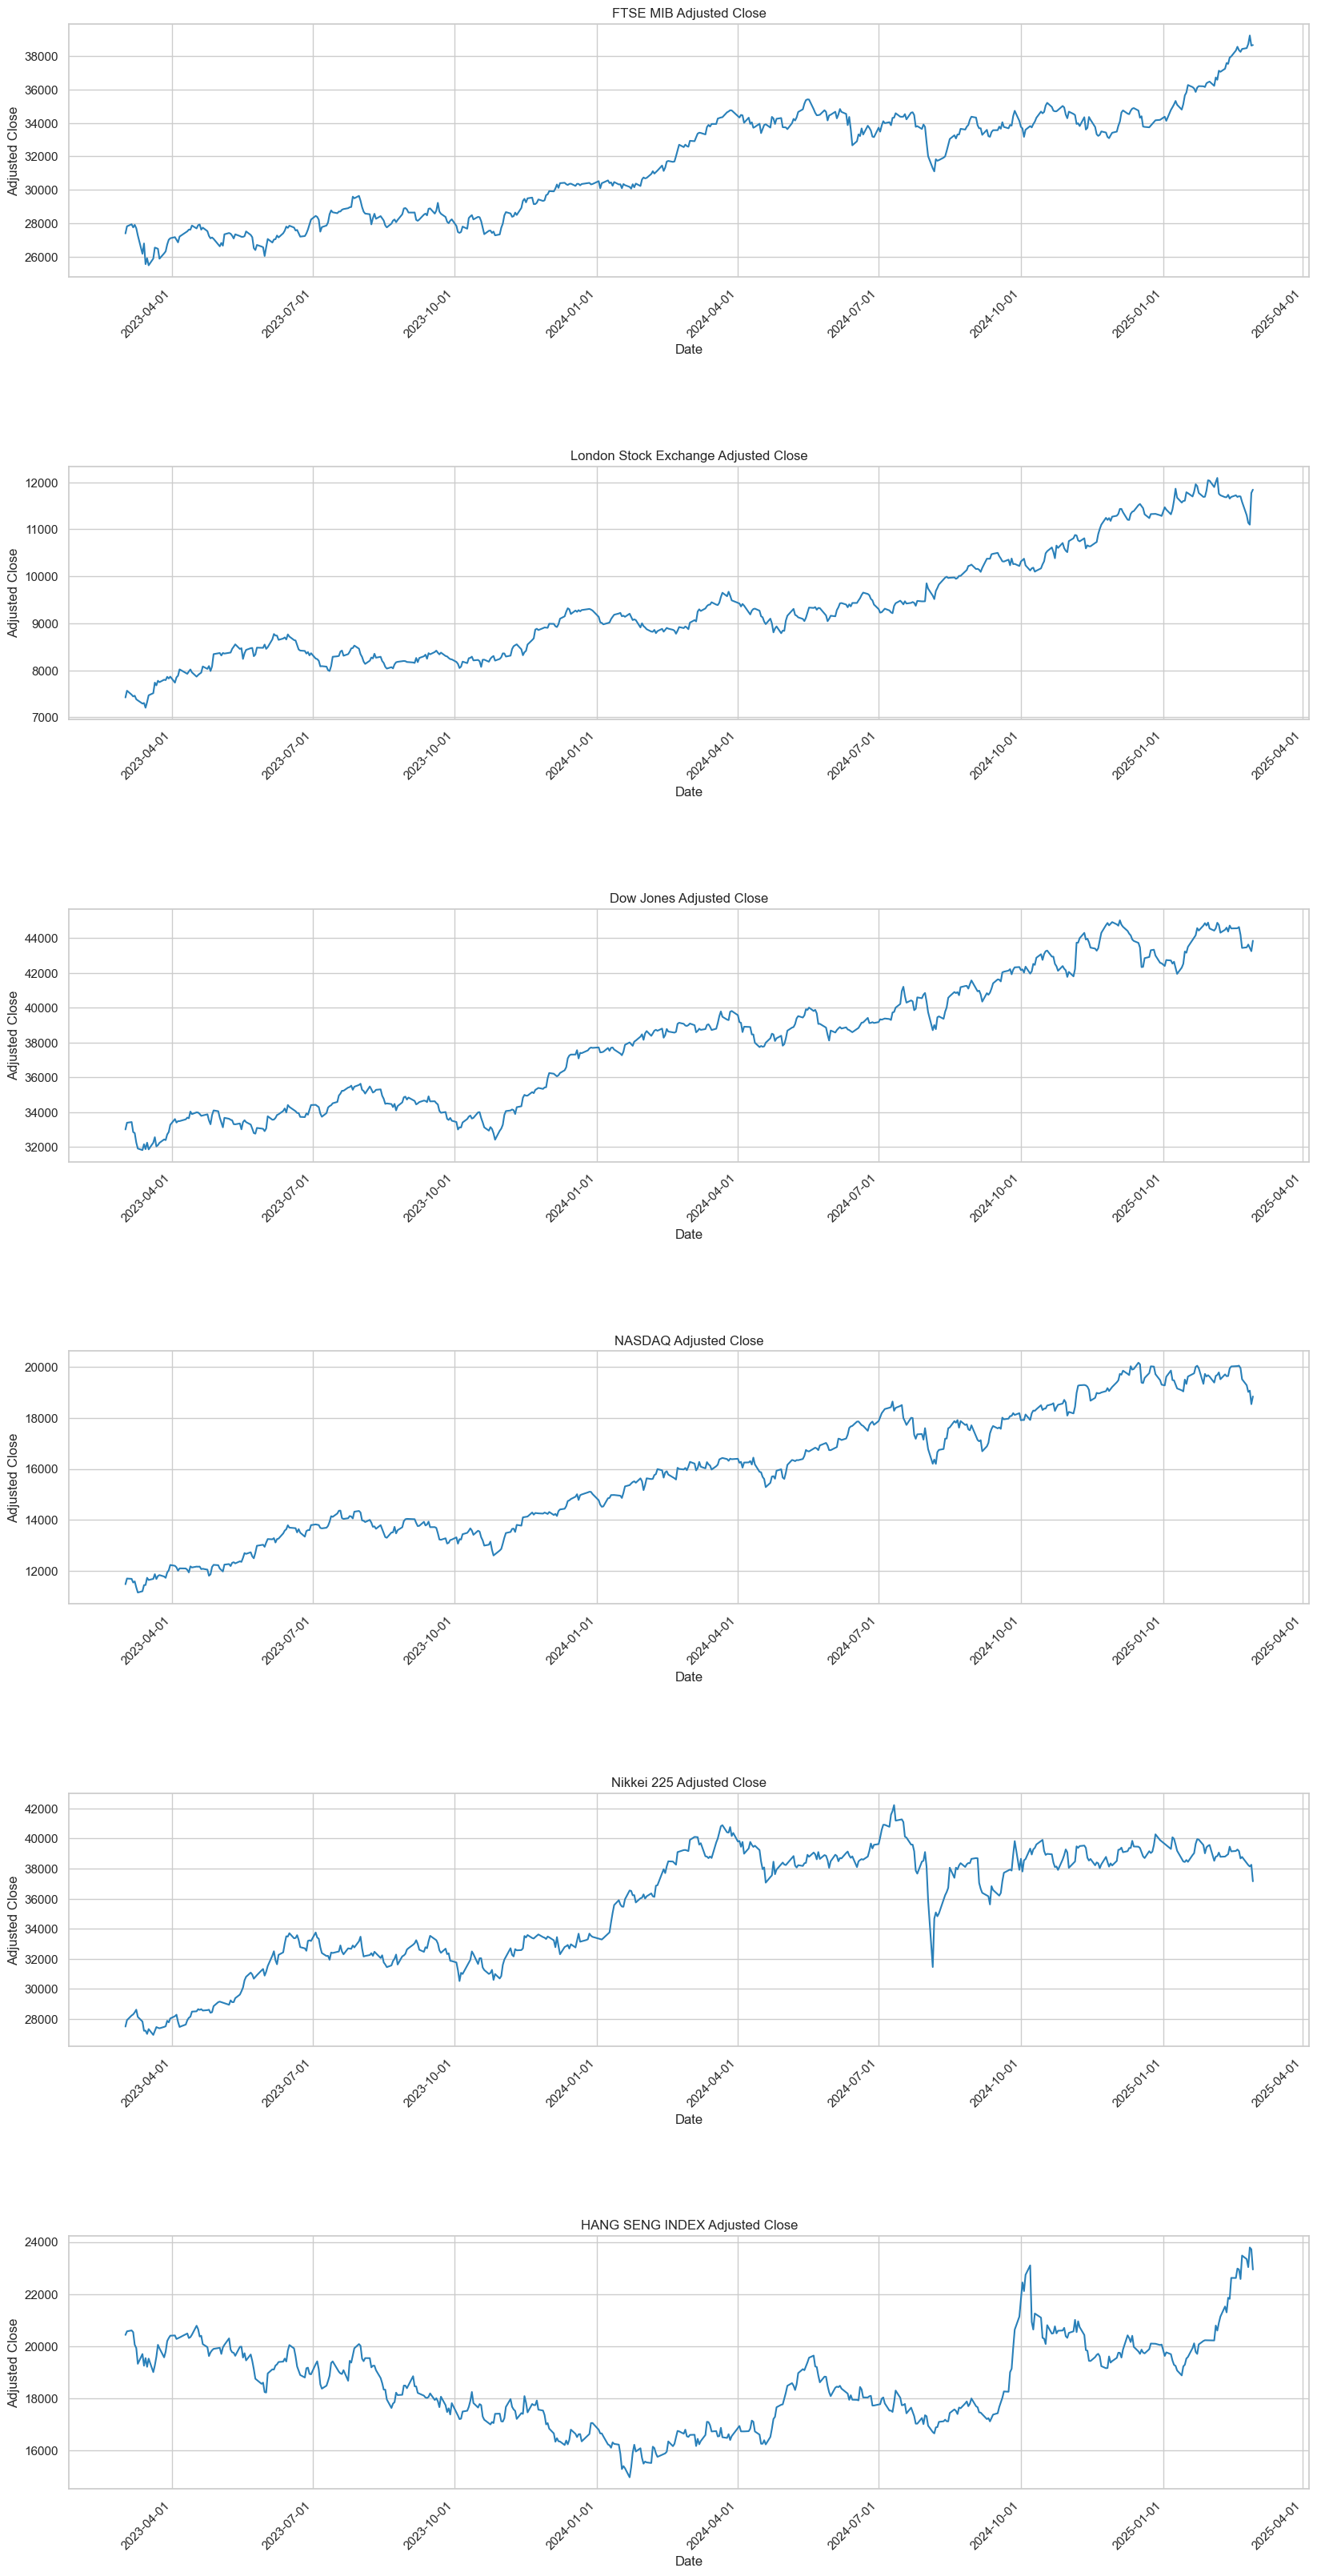

In [82]:
dfs_adj_closes = []
for index in injector.indexes:
    dfs_adj_closes.append(index.df)
multi_plot_in_row(dfs=dfs_adj_closes, plot_names=injector.get_indexes_names(), info=IndexMeta.ADJUSTED_CLOSE)

\[Figura 1\]

In [83]:
fig_2 = """
    <h3 id="fig_2">Grafico dei rendimenti logaritmici%</h3>
"""
display(HTML(fig_2))

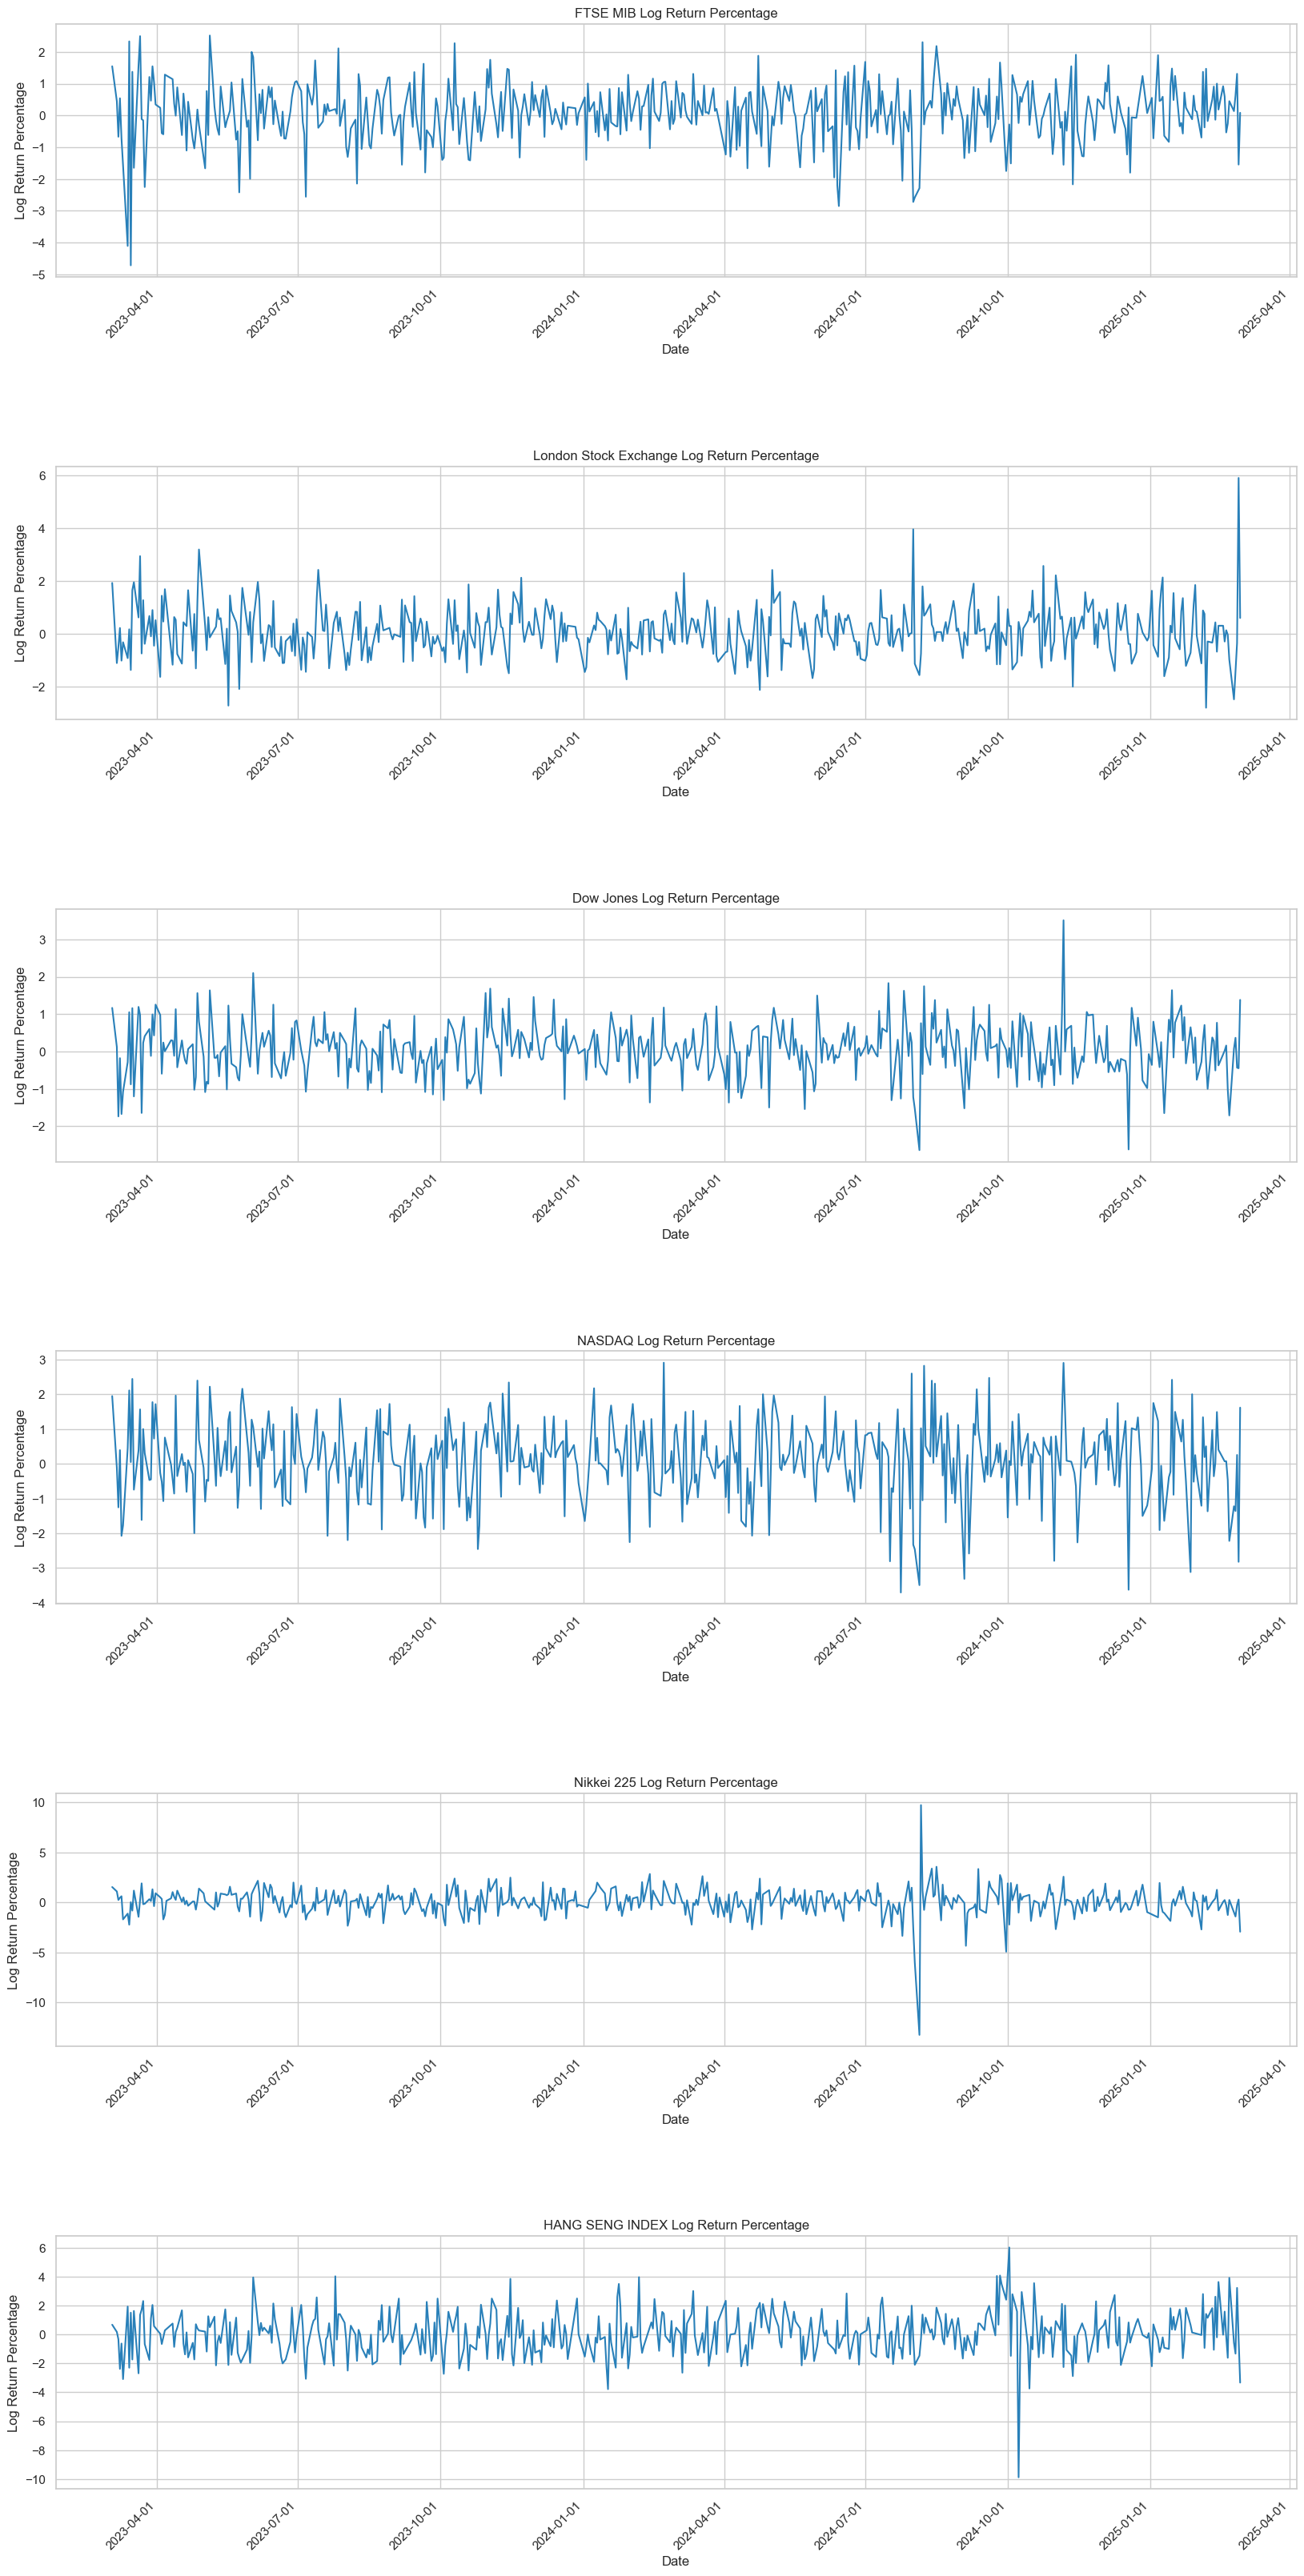

In [84]:
dfs_log_ret = []
for index in injector.indexes:
    dfs_log_ret.append(index.daily_info)
multi_plot_in_row(dfs=dfs_log_ret, plot_names=injector.get_indexes_names())

\[Figura 2\]

## 3) Analisi del Dataset
Bisogna ora verificare se il dataset ha i requisiti per poter usare un modello GARCH.
### 3.1) [Test ADF](#tab_1)
Verifica la presenza di una radice unitaria.
- Ipotesi nulla: serie temporale non è stazionaria (ha una radice unitaria).
### 3.2) [Test KPSS](#tab_3)
Verifica la stazionarietà della serie temporale.
- Ipotesi nulla: serie temporale stazionaria.
### 3.3) [Test di Engle (ARCH Test)](#tab_5)
Verifica la presenza di eteroschedasticità condizionata.
- Ipotesi nulla: la serie temporale non presenta eteroschedasticità condizionata (varianza costante nel tempo).

In [85]:
P_VALUE = 0.05
"""
 Value for what test is passed or not
"""


def adfuller_test(indexes, target=IndexMeta.ADJUSTED_CLOSE):
    """
        :param indexes: List 
        :param target: column to target of the dataset
    """
    
    res = {}
    for index in indexes: 
        df_target = None
        name = ""
        if isinstance(index, Index):
            df_target = index.get_df_by_name(target)
            name = index.i_name
        else:
            df_target = indexes[index]['DataSet'][target]
            name = index
        adf_res = adfuller(df_target)
        res[name] = {
            'adf' : adf_res,
            'parameter': target
        }
        res[name]['outcome'] = f'{"accepted" if res[name]["adf"][1] > P_VALUE else "rejected"}'
    return res

def kpss_test(indexes, target=IndexMeta.ADJUSTED_CLOSE):
    res = {}
    for index in indexes: 
        df_target = None
        name = ""
        if isinstance(index, Index):
            df_target = index.get_df_by_name(target)
            name = index.i_name
        else:
            df_target = indexes[index]['DataSet'][target]
            name = index
        kpss_res = kpss(df_target)
        res[name] = {
            'kpss' : kpss_res,
            'parameter': target
        }
        res[name]['outcome'] = f'{"accepted" if res[name]["kpss"][1] > P_VALUE else "rejected"}'
    return res

def het_arch_test(indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE):
    res = {}

    for index in indexes: 
        df_target = (index.get_df_by_name(target).rolling(window=21).std() * np.sqrt(252)).dropna()
        het_arch_res = het_arch(df_target)
        res[index.i_name] = {
            'engles arch' : het_arch_res,
            'parameter': target
        }
        res[index.i_name]['outcome'] = f'{"accepted" if res[index.i_name]["engles arch"][1] > P_VALUE else "rejected"}'
    return res

def ljung_box_test(indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE, squared=False):
    res = {}

    for index in indexes:
        df_target = None
        name = ""
        if isinstance(index, Index):
            df_target = index.get_df_by_name(target)
            name = index.i_name
        else:
            if squared:
                df_target = indexes[index]['DataSet'][target] ** 2
            else: 
                df_target = indexes[index]['DataSet'][target]
            name = index
        ljb_res = acorr_ljungbox(df_target, lags=[21], return_df=True)
        ljb_local = (ljb_res.at[21,"lb_stat"], ljb_res.at[21,"lb_pvalue"])
        res[name] = {
            'ljung box' : ljb_local,
            'parameter': target
        }
        res[name]['outcome'] = f'{"accepted" if res[name]["ljung box"][1] > P_VALUE else "rejected"}'
    return res        

In [86]:
adjusted_closes_adf = adfuller_test(indexes=injector.indexes, target=IndexMeta.ADJUSTED_CLOSE)
log_ret_perc_adf = adfuller_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)


In [87]:
tab_1 = """
<h4 id="tab_1">Test ADF Chiusura Rettificata</h4>
<p>Qui si fa il test sui Prezzi rettificati ci si aspetta che l'ipotesi nulla sia accettata. I prezzi generalmente non sono stazionari.</p>
"""
display(HTML(tab_1))

In [88]:
adjusted_closes_adf_table = print_res_test(adjusted_closes_adf).T.to_html(classes='styled-table-2', escape=False)
adjusted_closes_adf_table = """
<h4 id="tab_1">Test ADF Chiusura Rettificata</h4>
<p>Qui si fa il test sui Prezzi rettificati ci si aspetta che l'ipotesi nulla sia accettata. I prezzi generalmente non sono stazionari.</p>
""" + adjusted_closes_adf_table
display(Markdown(adjusted_closes_adf_table))


<h4 id="tab_1">Test ADF Chiusura Rettificata</h4>
<p>Qui si fa il test sui Prezzi rettificati ci si aspetta che l'ipotesi nulla sia accettata. I prezzi generalmente non sono stazionari.</p>
<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>-0.16647</td>
      <td>0.942402</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>-0.249592</td>
      <td>0.932346</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>-0.603598</td>
      <td>0.870167</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>-1.25771</td>
      <td>0.648291</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>-2.121632</td>
      <td>0.235906</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>-1.443634</td>
      <td>0.561188</td>
      <td>accepted</td>
    </tr>
  </tbody>
</table>

\[Tabella 1\]

In [89]:
tab_2 = """
<h4 id="tab_2">Test ADF Ritorno logaritmico in percentuale</h4>
<p>Nei dati di mercato si aspetta che i rendimenti logaritmici siano stazionari quindi, il test rigetta l'ipotesi nulla che non siano stazionari.</p>
"""
display(HTML(tab_2))

In [90]:
from IPython.display import display, Markdown
log_ret_perc_adf_table = print_res_test(log_ret_perc_adf).T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_adf_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>-23.10197</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>-13.59598</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>-20.843199</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>-22.239244</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>-23.203279</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>-11.932728</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 2\]

### Interpretazione ADF
L'interpretazione del test ADF è particolarmente rilevante per le serie storiche finanziarie. Le chiusure rettificate, infatti, tendono a non essere stazionarie, mentre i rendimenti lo sono. Pertanto, per il modello GARCH(1,1), questo primo test suggerisce l'uso dei rendimenti logaritmici.

In [9]:
tab_3 = """
    <h4 id="tab_3">Test Kpss chiusura Rettificata</h4>
    <p>Ci si aspetta di rifiutare l'ipotesi nulla del test KPSS, che assume la stazionarietà della serie delle chiusure rettificate dei prezzi.<br>
    Questo risultato è coerente con il test ADF, che indica che i prezzi non sono stazionari<a href="#tab_1">[Tabella 1]</a>.</p>
"""
display(HTML(tab_3))


In [95]:
adjusted_closes_kpss_table = print_res_test(adjusted_closes_kpss, test='kpss').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(adjusted_closes_kpss_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>3.379743</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>3.275608</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>3.749713</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>3.808114</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>3.157287</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>0.861749</td>
      <td>0.01</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 3\]

In [10]:
tab_4 = """
    <h4 id="tab_4">Test Kpss Ritorno logarimico</h4>
    <p>Ci si aspetta che l'ipotesi nulla venga accettata in quanto in <a href="#tab_2">[Tabella 2]</a>, viene rifiutato il test ADF</p>
"""
display(HTML(tab_4))

In [92]:
%%capture
adjusted_closes_kpss = kpss_test(indexes=injector.indexes, target=IndexMeta.ADJUSTED_CLOSE)
log_ret_perc_kpss = kpss_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)

In [93]:
log_ret_perc_kpss_table = print_res_test(log_ret_perc_kpss, test='kpss').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_kpss_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>0.064153</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>0.052536</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>0.031371</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>0.084201</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>0.168704</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>0.288405</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
  </tbody>
</table>

\[Tabella 4\]

### Interpretazione KPSS
Il test KPSS conferma chiaramente che le chiusure rettificate non sono stazionarie, mentre i ritorni logaritmici lo sono. In altre parole, l'ipotesi nulla del test KPSS, secondo cui la serie sarebbe stazionaria, viene respinta per le chiusure rettificate, evidenziando la presenza di trend o altre dinamiche che alterano la stazionarietà.
Al contrario, i ritorni logaritmici, calcolati come la differenza tra i logaritmi dei prezzi, eliminano queste componenti non stazionarie, risultando in una serie più adatta
alle analisi statistiche.
Questa evidenza, confermata anche dai risultati del test ADF, rende evidente che, per l'applicazione di modelli econometrici come il GARCH(1,1) — che richiedono serie stazionarie per una corretta specificazione e previsione della volatilità — l'utilizzo dei ritorni logaritmici è la scelta più appropriata

In [96]:
tab_5 = """
    <h4 id="tab_5">Test Engle's Arch Ritorno sulla volatilià</h4>
    <p>Si decidere di prendere in considerazione i rendimenti logaritmici e si testa la volatilità realizzata su una finestra mobile di 21 giorni</p>
"""
display(HTML(tab_5))


In [97]:
log_ret_perc_het_arch = het_arch_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)

In [98]:
log_ret_perc_het_arch_table = print_res_test(log_ret_perc_het_arch, test='engles arch').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_het_arch_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>447.565236</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>419.526856</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>433.122914</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>448.361485</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>448.653216</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>439.510562</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 5\]

### Interpretazione Engle's Arch
Il test di Engle's ARCH verifica la presenza di effetti ARCH, ovvero variazioni condizionali della varianza nel tempo. In questo caso, il test rigetta l'ipotesi nulla per tutti i mercati analizzati, indicando che la varianza non rimane costante nel tempo. Questo risultato evidenzia una struttura di volatilità dinamica nelle serie, rendendo necessari modelli come il GARCH per una corretta modellizzazione della varianza.

In [99]:
fig_3 = """
    <h3 id="fig_4">3.5) Plot delle volatilità Realizzate Annualizzate</h3>
"""
display(HTML(fig_3))

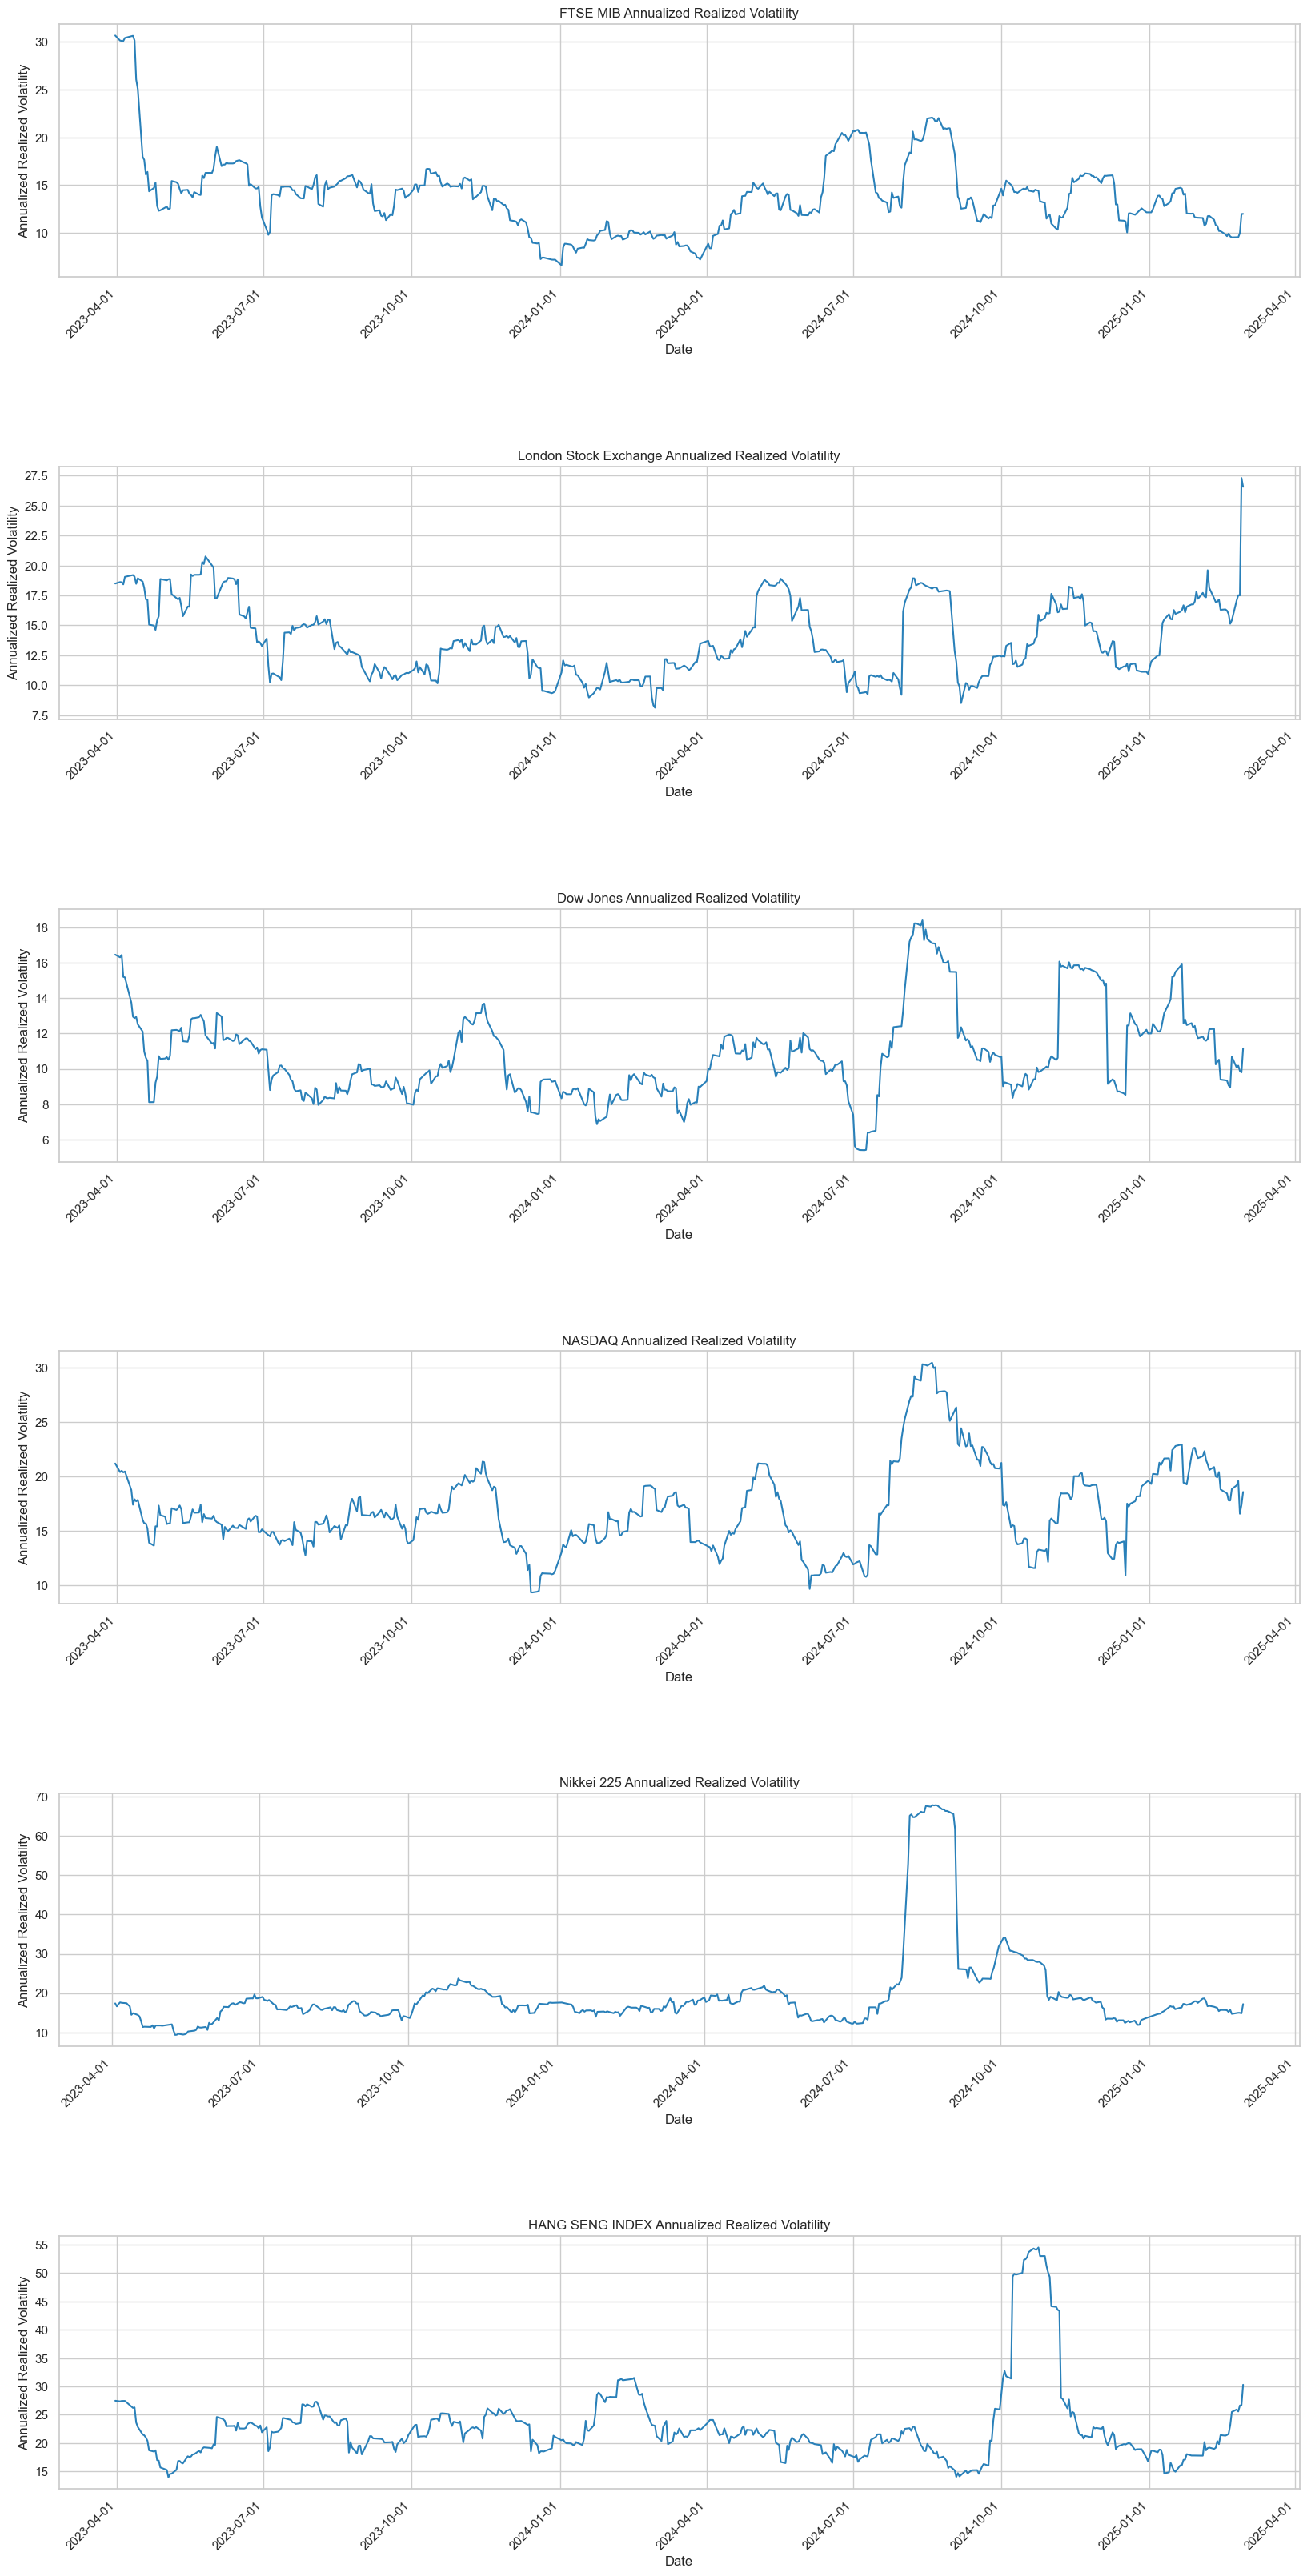

In [100]:
volatilities_annualized = []
for index in injector.indexes: 
    volatilities_annualized.append(index.realized_volatility)
multi_plot_in_row(dfs=volatilities_annualized, plot_names=injector.get_indexes_names(), info=IndexMeta.ANNUALIZED_REALIZED_VOLATILITY)

\[Figura3\]

### 3.6) [Test di Shapiro-Wilk](#tab_6)
Verifica se la serie temporale segue una distribuzione normale.
- Ipotesi nulla: la serie temporale segue una distribuzione normale.
### 3.7) [Test di D’Agostino-Pearson](#tab_7)
Verifica se la serie temporale segue una distribuzione normale, considerando asimmetria (skewness) e curtosi (kurtosis).
- Ipotesi nulla: la serie temporale segue una distribuzione normale.
### 3.8) [Test di Jarque-Bera](#tab_8)
Verifica se la serie temporale segue una distribuzione normale basandosi su skewness e kurtosis.
- ipotesi nulla: la serie temporale segue una distribuzione normale


In [101]:
def shapiro_test(indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE):
    res = {}
    for index in indexes: 
        df_target = index.get_df_by_name(target)
        shapiro_res = shapiro(df_target)
        res[index.i_name] = {
            'shapiro' : shapiro_res,
            'parameter': target
        }
        res[index.i_name]['outcome'] = f'{"accepted" if res[index.i_name]["shapiro"].pvalue > P_VALUE else "rejected"}'
    return res


def agostino_person_test(indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE):
    res = {}
    for index in indexes: 
        df_target = index.get_df_by_name(target)
        normaltest_res = normaltest(df_target)
        res[index.i_name] = {
            'agostino-person' : normaltest_res,
            'parameter': target
        }
        res[index.i_name]['outcome'] = f'{"accepted" if res[index.i_name]["agostino-person"].pvalue > P_VALUE else "rejected"}'
    return res

def jarque_bera_test (indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE):
    res = {}
    for index in indexes: 
        df_target = index.get_df_by_name(target)
        jarque_bera_res = jarque_bera(df_target)
        res[index.i_name] = {
            'jarque-bera' : jarque_bera_res,
            'parameter': target
        }
        res[index.i_name]['outcome'] = f'{"accepted" if res[index.i_name]["jarque-bera"].pvalue > P_VALUE else "rejected"}'
    return res


In [102]:
log_ret_perc_shapiro = shapiro_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)

In [103]:
tab_6 = """
    <h4 id="tab_6">Shapiro Test Sui rendimenti Logaritmici</h4>
"""
display(HTML(tab_6))

In [104]:
log_ret_perc_shapiro_table = print_res_test(log_ret_perc_shapiro, test='shapiro').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_shapiro_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>0.973648</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>0.969968</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>0.988167</td>
      <td>0.000449</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>0.986894</td>
      <td>0.000181</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>0.853451</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>0.968064</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 6\]

In [105]:
log_ret_perc_agostino_pearson = agostino_person_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)  

In [106]:
tab_7 = """
    <h4 id="tab_7">Agostino Pearson Test sui Rendimenti Logaritmici</h4>
"""
display(HTML(tab_7))

In [107]:
log_ret_perc_agostino_pearson_table = print_res_test(log_ret_perc_agostino_pearson, test='agostino-person').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_agostino_pearson_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>59.622021</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>76.842388</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>17.926155</td>
      <td>0.000128</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>16.469706</td>
      <td>0.000265</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>238.137326</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>48.436843</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 7\]

In [108]:
log_ret_perc_jarque_bera = jarque_bera_test(indexes=injector.indexes, target=IndexMeta.LOG_RETURN_PERCENTAGE)  

In [109]:
tab_8 = """
    <h4 id="tab_8">Jarque Bera Test sui Rendimenti Logaritmici</h4>
"""
display(HTML(tab_8))

In [110]:
from IPython.display import display, Markdown
log_ret_perc_jarque_bera_table = print_res_test(log_ret_perc_jarque_bera, test='jarque-bera').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(log_ret_perc_jarque_bera_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>126.43617</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>268.987568</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>42.293826</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>18.570969</td>
      <td>0.000093</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>9682.249045</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>252.288181</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 8\]

In [12]:
qq_plots = """
    <h3 id = "qq-plots-1">3.6) QQ-Plot</h3>
    <p>Il QQ-Plot (Quantile-Quantile Plot) è uno strumento grafico utilizzato per confrontare la distribuzione dei dati osservati con una distribuzione teorica di riferimento,
    ad esempio la distribuzione normale.<br> Se i punti del QQ-Plot si allineano lungo una retta, ciò indica che la distribuzione dei dati è simile a quella teorica.<br>
    In caso contrario, eventuali deviazioni dalla retta possono segnalare asimmetria, code pesanti o altre anomalie nella distribuzione.</p>
"""
display(HTML(qq_plots))

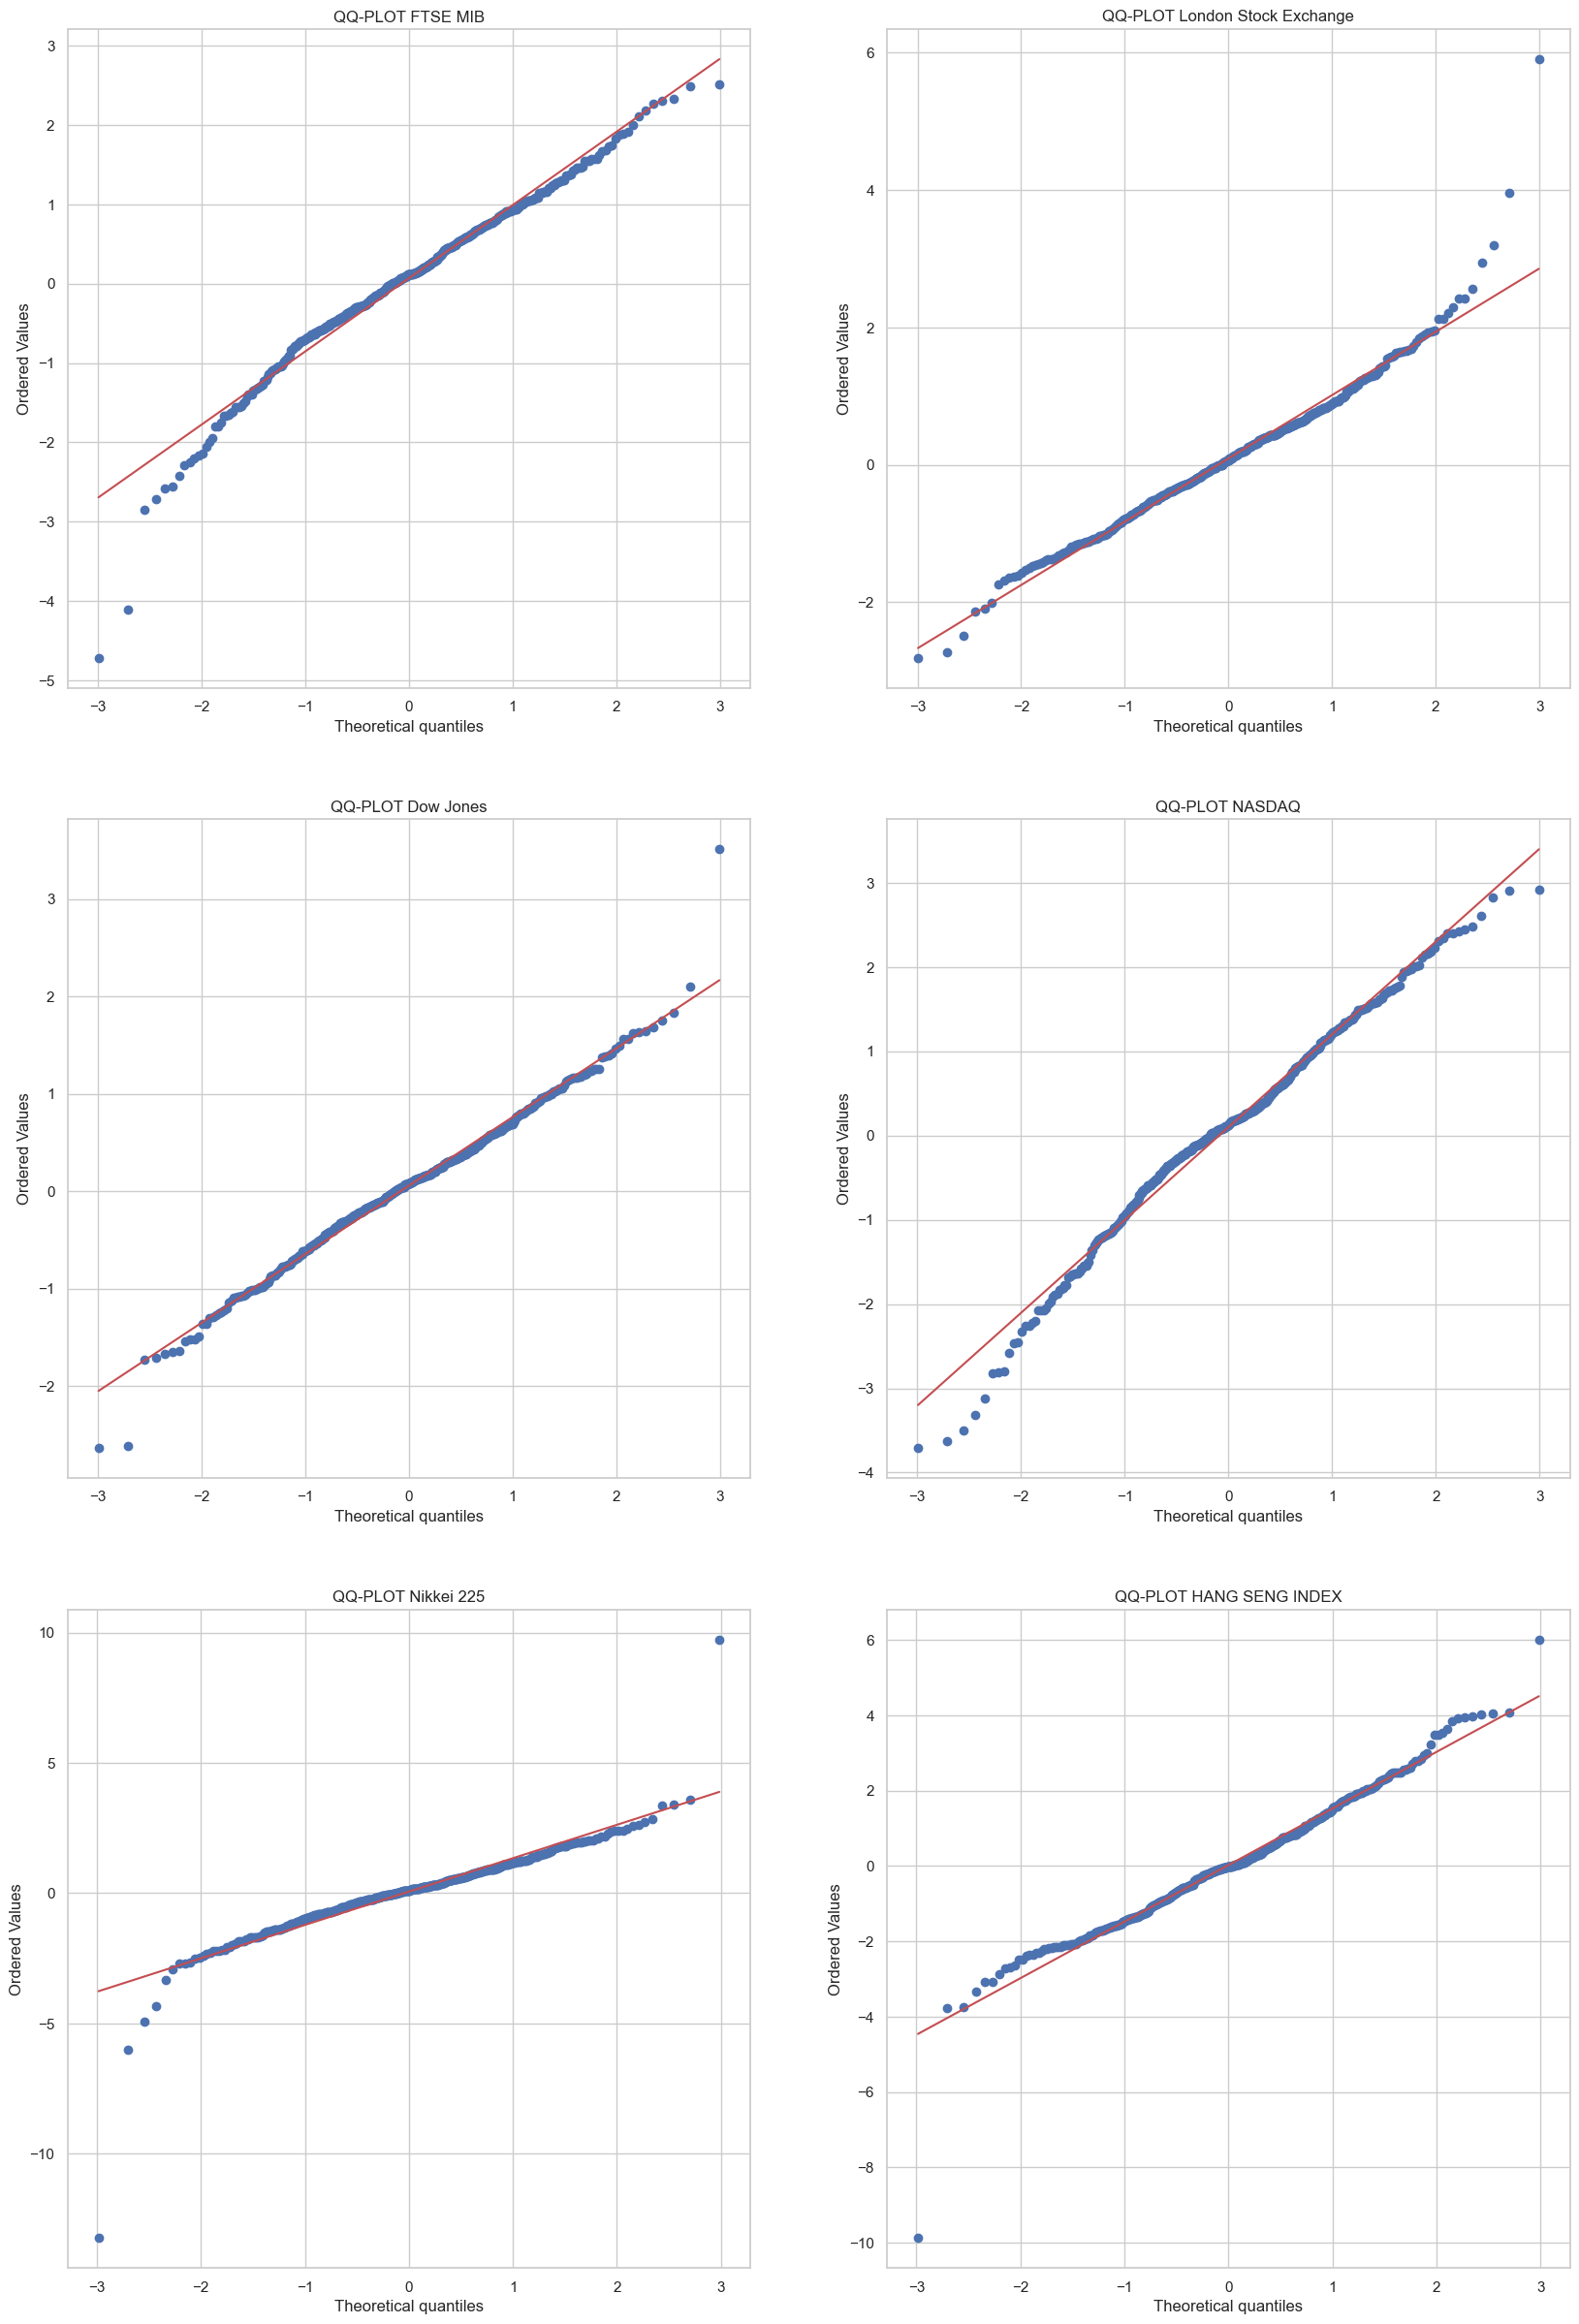

In [226]:
def show_qq():
    x = 0
    if len(injector.indexes) % 2 != 0:
        x = 1

    fig, axs = plt.subplots(int(len(injector.indexes) / 2) + x, 2, figsize=(20,30))
    i = 0
    j = 0
    for index in injector.indexes:
        stats.probplot(index.daily_info[IndexMeta.LOG_RETURN_PERCENTAGE], dist="norm", plot=axs[i][j])
        axs[i][j].set_title(f'QQ-PLOT {index.i_name}')
        j += 1
        if j % 2 == 0:
            j = 0
            i+=1

    plt.show()
show_qq()

## 4) Modelli GARCH

I modelli GARCH (Generalized Autoregressive Conditional Heteroskedasticity) sono strumenti fondamentali per analizzare e prevedere la volatilità nelle serie temporali finanziarie, come i prezzi azionari, i tassi di cambio o i tassi di interesse. Essi risultano particolarmente utili quando la variabilità dei dati non è costante nel tempo, ma varia in maniera periodica.

### 4.1) Motivazione per l'uso dei modelli GARCH

Nei mercati finanziari la volatilità dei rendimenti tende a variare: durante periodi di crisi essa aumenta, mentre in momenti di stabilità può diminuire. I modelli GARCH sono concepiti per catturare questa dinamica, modellando la volatilità futura come funzione dei valori passati della volatilità stessa e degli errori di previsione antecedenti.

### 4.2) Struttura del modello GARCH

Un modello GARCH si compone di due componenti principali:

- **Autoregressiva (AR):** cattura la dipendenza della serie dai valori passati.
- **Condizionale (CH):** modella la volatilità condizionale (varianza) in funzione dei dati storici.

Una formulazione standard di un modello GARCH(p, q) è la seguente:

$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t e_t$$
$$\sigma^2_t = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1}$$

dove:
- $r_t$ è il rendimento al tempo $t$;
- $\mu$ rappresenta la media della serie;
- $\epsilon_t$ è l'errore al tempo $t$, influenzato dalla volatilità condizionale $\sigma^2_t$;
- $\omega$, $\alpha$ e $\beta$ sono parametri da stimare.
- $\sigma^2_t$ La volatilità condizionale è espressa come una combinazione lineare degli errori passati e della volatilità del periodo precedente.

### 4.3) Scelta del modello f-GARCH (Sottmodello GARCH(1,1))

Dall'analisi dei dati si osserva che la volatilità aumenta in misura maggiore a seguito di shock negativi, evidenziando un effetto asimmetrico. Per modellare questa caratteristica, è stata scelta una variante flessibile del GARCH, nota come **f-GARCH**.

Una possibile specificazione del modello f-GARCH è la seguente:

- $r_t = \mu + \epsilon_t$
- $\epsilon_t = \sigma_t z_t$
- $\sigma^2_t = \omega + \alpha\, f(\epsilon_{t-1}) + \beta \sigma^2_{t-1}$

dove la funzione $f(\cdot)$ è studiata per catturare l'impatto asimmetrico degli shock. Ad esempio, una specificazione comune è:

$f(\epsilon_{t-1}) = \left( |\epsilon_{t-1}| - \gamma\, \epsilon_{t-1} \right)^2$

In questa formulazione, un valore positivo di $\gamma$ implica che gli shock negativi influenzano la volatilità in maniera più marcata rispetto agli shock positivi.

Per la fase di stima, il 90% del dataset è stato utilizzato per il fitting del modello, mentre la scelta della distribuzione degli errori è stata effettuata mediante il criterio della massima verosimiglianza, al fine di individuare la distribuzione che meglio rappresenta le caratteristiche empiriche dei dati.


In [199]:
class GarchUtil:
    
    def __init__(self, indexes: list[Index] = None, col=IndexMeta.LOG_RETURN_PERCENTAGE, split=0.9):
        self.indexes: list[Index] = indexes
        self.col = col
        self.trains = {}
        self.tests = {}
        if indexes is None:
            self.indexes = []
        
        self.make_train_and_test(split=split)
    
    def make_train_and_test(self, split=0.9):
        self.trains: list[pd.DataFrame] = {}
        self.tests: list[pd.DataFrame] = {}
        for index in self.indexes:
            df = index.get_df_by_name(self.col)
            cut = int(len(df)*split)
            self.trains[index.i_name] = pd.DataFrame(df.iloc[:cut])
            self.tests[index.i_name] = pd.DataFrame(df.iloc[cut:])
    
    def get_index_by_name(self, name) -> Index:
        for index in self.indexes:
            if name == index.i_name:
                return index
        return None

def r2py_array_to_list (array) -> list:
    ret = []
    for element in array:
        ret.append(element[0])
    return ret


"""
    +------------+
    | FGARCH-FIT |
    +------------+------------------+
    | Check file in R/Garch_model.R |
    +-------------------------------+
"""


def gen_trajectories(garch_util: GarchUtil, num_sims=200):
    trajectories = []
    
    

def ru_garch_in_R(garch_util: GarchUtil, num_sims=200):
    indexes = garch_util.indexes
    if indexes is None:
        return
    pandas2ri.activate()
    ro.r('Sys.getlocale()')
    ro.r('Sys.setlocale("LC_ALL", "en_US.UTF-8")')
    ro.r('source("R/Garch_model.R")')
    get_garch_best_models = ro.r['get_garch_best_models']
    garch_model_infos = {}
    
    trains = garch_util.trains
    tests = garch_util.tests
    for index in indexes:
        name = index.i_name
        ret = trains[name]
        forecast_horizon = len(tests[name])
        r_ret = ro.conversion.py2rpy(ret)
        r_fh = ro.conversion.py2rpy(forecast_horizon)
        r_func_ret = get_garch_best_models(r_ret, forecast_horizon)
        df_res = ret.copy()
        df_res[IndexMeta.GARCH_RESIDUALS] = ro.conversion.rpy2py(r_func_ret[3])
        df_res.drop(columns=[IndexMeta.LOG_RETURN_PERCENTAGE], inplace=True)
        index.residuals = df_res
        
        # Generating dataframe for Forecast
        sigma = r2py_array_to_list(ro.conversion.rpy2py(r_func_ret[4]))
        series = r2py_array_to_list(ro.conversion.rpy2py(r_func_ret[5]))
        T_0 = tests[name].head().index[0]
        #dates = pd.date_range(start=T_0, periods=forecast_horizon, freq='B')

        # dataframe for the forecast
        forecast_df = pd.DataFrame(
            {
                IndexMeta.GARCH_FORECAST_SERIES : series,
                IndexMeta.GARCH_FORECAST_SIGMA : sigma
            }, index=tests[name].index
        )

        index.forecast = forecast_df
        index.model = {
            'fGARCH[GARCH(1,1)]' : {
                "index": name,
                "dist": str(r_func_ret[0][0]),
                "information_criteria": {
                    "shibata": float(r_func_ret[1][0]),
                },
                IndexMeta.GARCH_CONDITIONAL_VOLATILITY: pd.DataFrame({IndexMeta.GARCH_CONDITIONAL_VOLATILITY: ro.conversion.rpy2py(r_func_ret[2]).flatten()},
                                                                     index = trains[name].index),
                "params": {
                    "omega": float(r_func_ret[6][0]),
                    "alpha1": float(r_func_ret[7][0]),
                    "beta1": float(r_func_ret[8][0])
                }
            }
        }
        

    pandas2ri.deactivate()

In [200]:
%%capture
garch_util = GarchUtil(injector.indexes)
ru_garch_in_R(garch_util=garch_util)

### 4.4) Analisi Residui
Qui vengono effettuati i test che sono stati fatti per verificare la stazionarietà, fatti in precedenza, confrontando i risultati di 
[Tabella 2](#tab_2) e [Tabella 4](#tab_4)

In [116]:
%%capture
residual_adf = adfuller_test(indexes=injector.indexes, target=IndexMeta.GARCH_RESIDUALS)

In [117]:
tab_9 = """
<h4 id="tab_9">Test ADF Sui residui del modello GARHC</h4>
<p>Nei dati di mercato si aspetta che i residui siano stazionari quindi, il test rigetta l'ipotesi nulla che non siano stazionari.<br>
Come in <a href="#tab_2">[Tabella 2]
</p>
"""
display(HTML(tab_9))

In [118]:
residual_adf_table = print_res_test(residual_adf, test='adf').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(residual_adf_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>-20.92394</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>-21.761695</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>-21.127929</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>-20.712209</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>-21.006405</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>-20.705364</td>
      <td>0.0</td>
      <td>rejected</td>
    </tr>
  </tbody>
</table>

\[Tabella 9\]

In [119]:
%%capture
residuals_kpss = kpss_test(indexes=injector.indexes, target=IndexMeta.GARCH_RESIDUALS)

In [120]:
tab_10 = """
    <h4 id="tab_4">Test Kpss Residui modello GARCH</h4>
    <p>Ci si aspetta che l'ipotesi nulla venga accettata in quanto ci si aspetta che i residui siano stazionari.<br>
    Come in <a href="#tab_4">[Tabella 4].</a></p>
"""
display(HTML(tab_10))

In [121]:
residuals_kpss_table = print_res_test(residuals_kpss, test='kpss').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(residuals_kpss_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>0.131667</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>0.079455</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>0.045209</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>0.255459</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>0.078818</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>0.162684</td>
      <td>0.1</td>
      <td>accepted</td>
    </tr>
  </tbody>
</table>

### Test di Ljung-Box (Autocorrelazione dei residui)
Controlla se esiste autocorrelazione nei residui di una serie temporale.
- Ipotesi nulla: I residui non sono autocorrelati (seguono un rumore bianco).\
    La serie temporale non presenta eteroschedasticità condizionata (varianza costante nel tempo).
- Ipotesi alternativa: I residui mostrano autocorrelazione, suggerendo che il modello non ha catturato tutta la dipendenza temporale.


In [122]:
residuals_ljung_box = ljung_box_test(indexes=injector.indexes, target=IndexMeta.GARCH_RESIDUALS)

In [123]:
tab_11 = """
    <h4 id="tab_11">Test Ljung-Box Residui modello GARCH</h4>
    <p>Ci si aspetta che l'ipotesi nulla venga accettata, indicando che i residui non presentano autocorrelazione e seguono un rumore bianco.<br>
"""

display(HTML(tab_11))

In [124]:
residuals_ljung_box_table = print_res_test(residuals_ljung_box, test='ljung box').T.to_html(classes='styled-table-2', escape=False)
display(Markdown(residuals_ljung_box_table))

<table border="1" class="dataframe styled-table-2">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Statistic</th>
      <th>PVALUE</th>
      <th>Null Hypotesis</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FTSE MIB</th>
      <td>17.766913</td>
      <td>0.663703</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>London Stock Exchange</th>
      <td>15.469911</td>
      <td>0.798656</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Dow Jones</th>
      <td>17.251441</td>
      <td>0.695756</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>NASDAQ</th>
      <td>16.982776</td>
      <td>0.71215</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>Nikkei 225</th>
      <td>17.124607</td>
      <td>0.703526</td>
      <td>accepted</td>
    </tr>
    <tr>
      <th>HANG SENG INDEX</th>
      <td>18.160555</td>
      <td>0.638822</td>
      <td>accepted</td>
    </tr>
  </tbody>
</table>

\[Tabella 11\]

## Grafico Residui

In [128]:
def residuals_scatter_plot(garch_util: GarchUtil, fig_size=(20, 25)):
    if garch_util is None:
        print('No GarchUtil provided')
        return 
    indexes = garch_util.indexes
    if indexes is None:
        print('No indexes found in GarchUtil')
        return

    colors = PlotColors.get_color_list()
    
    fig, axs = plt.subplots(len(indexes), 1, figsize=fig_size, gridspec_kw={'hspace': 0.6})

    for i, index in enumerate(indexes):
        residuals = index.residuals[IndexMeta.GARCH_RESIDUALS]
        time_index = residuals.index

        sns.scatterplot(x=time_index, y=residuals, color=colors[i % len(colors)], label=index.i_name, alpha=0.6, ax=axs[i])
        axs[i].set_title(f'Residui per {index.i_name}', fontsize=14)
        axs[i].set_ylabel(IndexMeta.LOG_RETURN_PERCENTAGE)
        axs[i].set_xlabel("Date", fontsize=12)
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
        #axs[i].legend(loc="lower center", bbox_to_anchor=(0.5, -0.7), ncol=3, frameon=True)
    plt.xticks(rotation=45)
    plt.show()

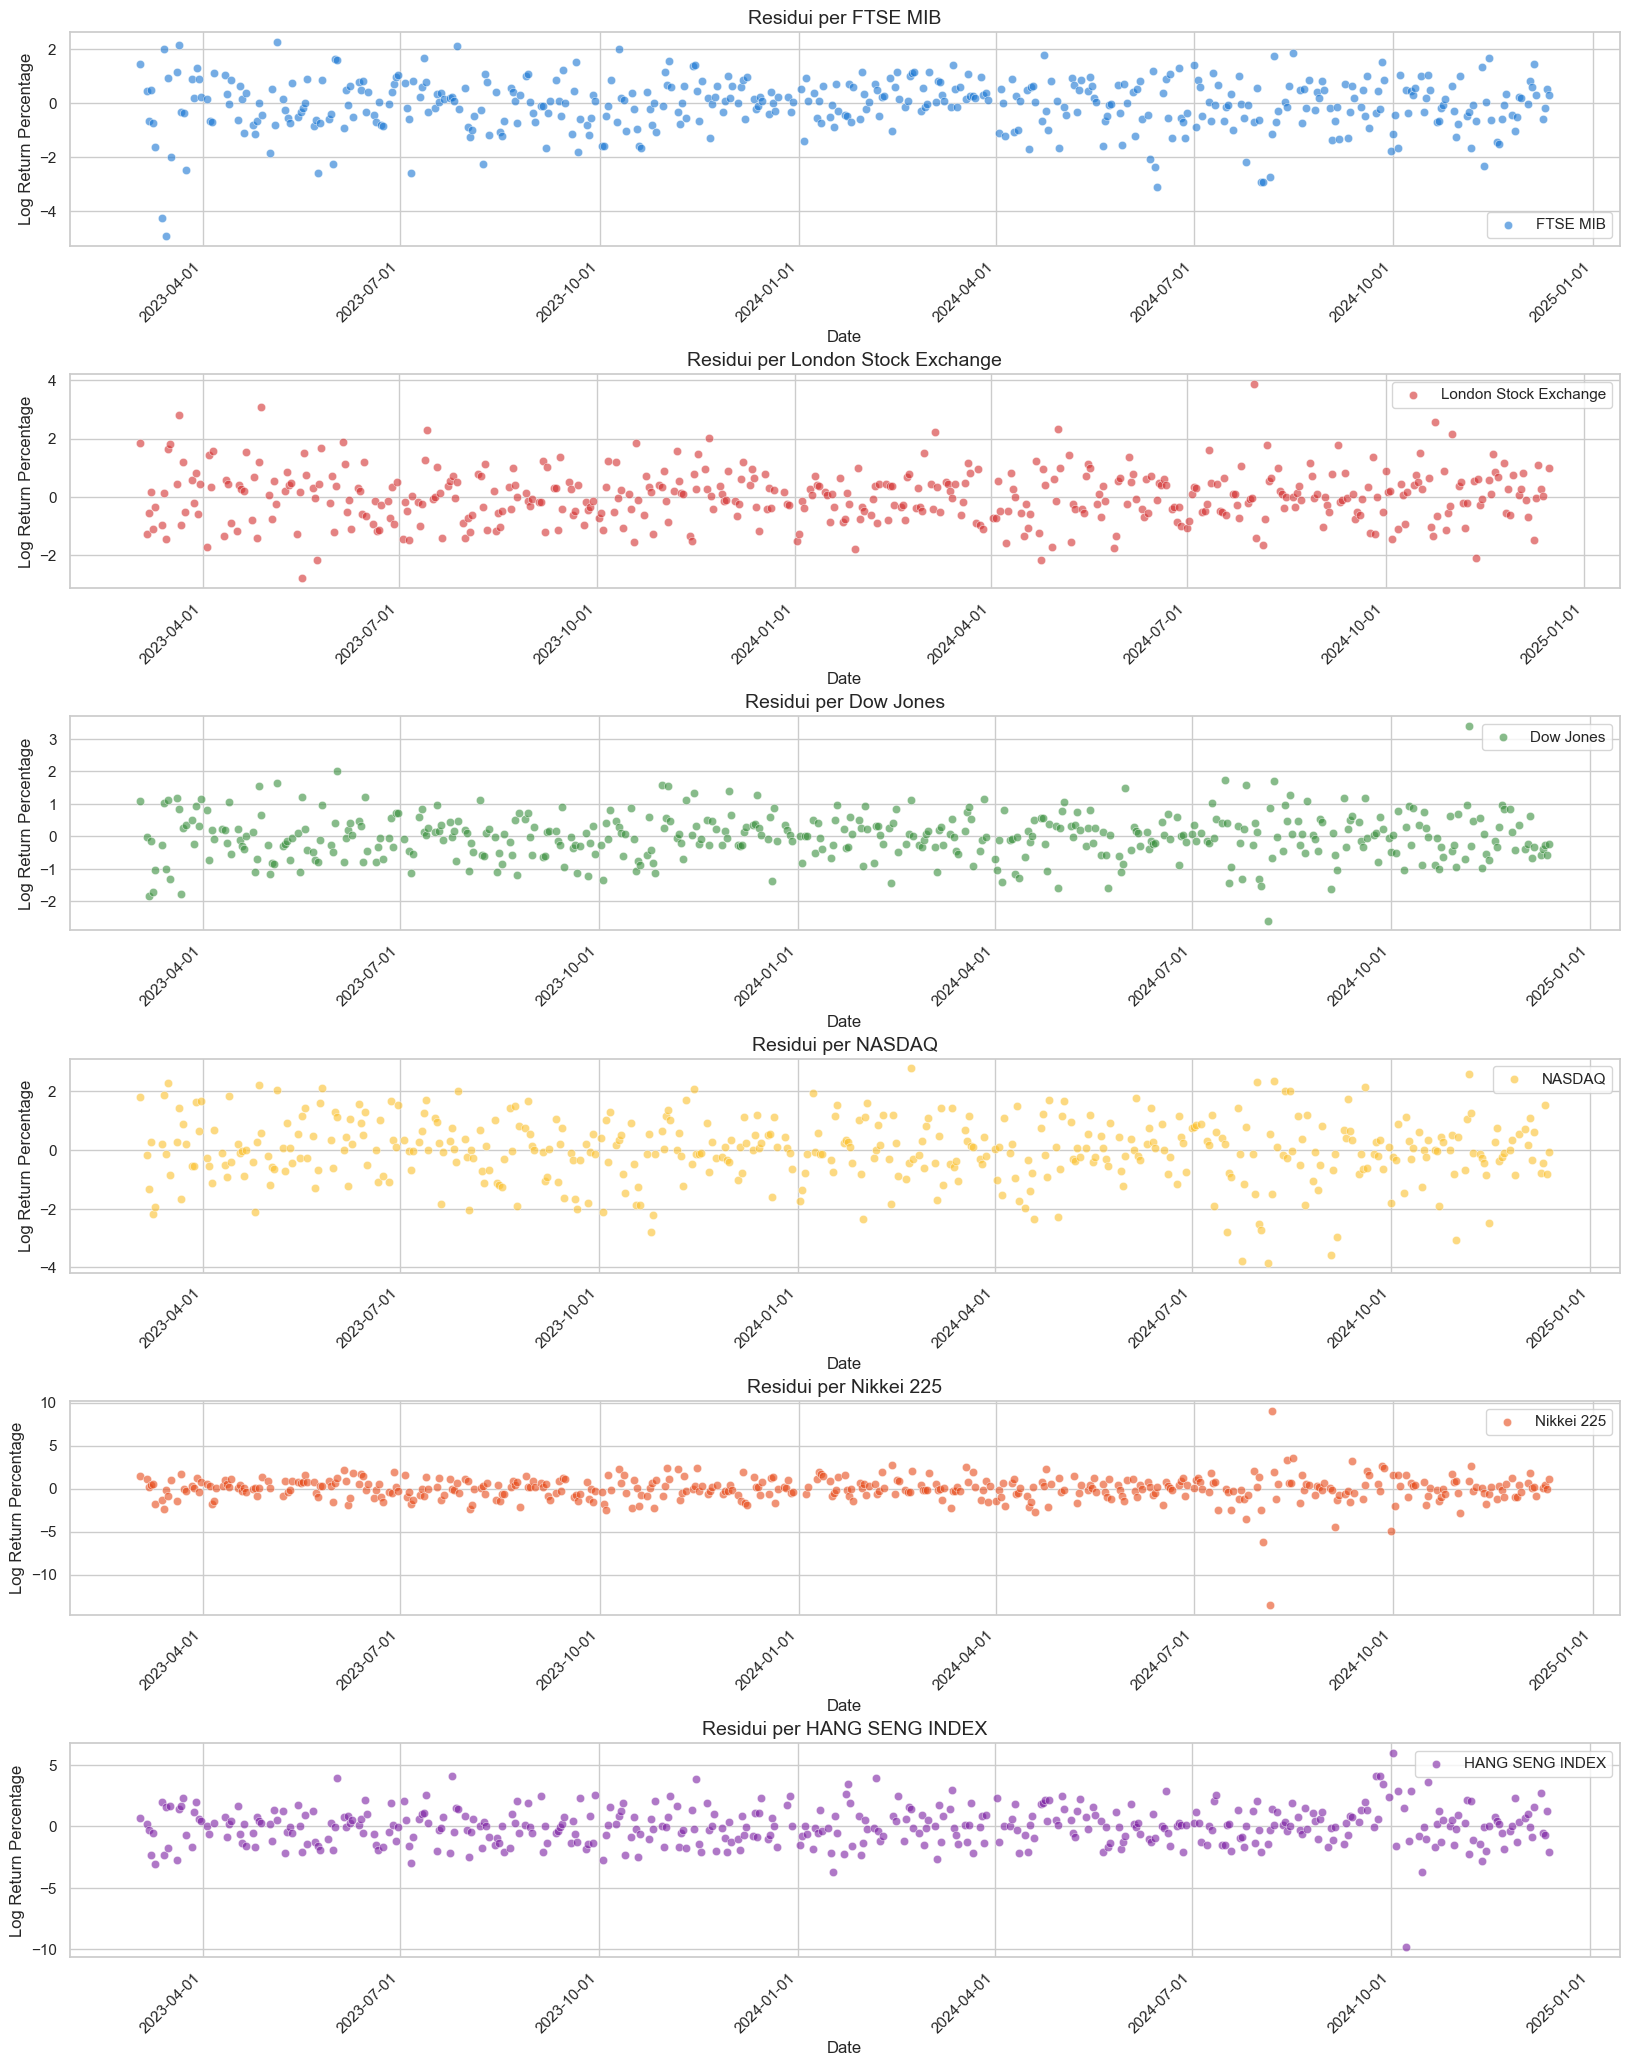

In [129]:
residuals_scatter_plot(garch_util)

### Generazione di Traiettorie Simulate
Questa sezione si occupa della simulazione di traiettorie di rendimento basate sul modello GARCH(1,1). Vengono generate più simulazioni per ciascun indice finanziario, partendo dai parametri stimati del modello. L'obiettivo è ottenere una rappresentazione delle possibili evoluzioni future della volatilità e dei rendimenti.

Le traiettorie simulate possono essere utilizzate successivamente per il plotting, consentendo un'analisi visiva della dispersione dei rendimenti e della loro volatilità attesa nel tempo. Inoltre, viene calcolata la traiettoria mediana, utile per avere un riferimento centrale tra le diverse simulazioni.

In [130]:
def gen_trajectories(garch_util, n_simulations=50, seed=20232024):
    indexes = garch_util.indexes
    trajectories = {}
    median_trajectories = {}

    np.random.seed(seed)

    for index in indexes:
        name = index.i_name
        params = index.model['fGARCH[GARCH(1,1)]']['params']
        omega, alpha, beta = params['omega'], params['alpha1'], params['beta1']
        horizon = len(garch_util.tests[name].index)

        simulated_returns = np.zeros((horizon, n_simulations))
        last_sigma2 = float(index.model['fGARCH[GARCH(1,1)]'][IndexMeta.GARCH_CONDITIONAL_VOLATILITY].mean().iloc[0]) ** 2

        for sim in range(n_simulations):
            sigma2 = last_sigma2  
            for t in range(horizon):
                epsilon = np.random.normal(0, 1)  
                simulated_returns[t, sim] = np.sqrt(sigma2) * epsilon
                sigma2 = omega + (alpha * (simulated_returns[t, sim] ** 2)) + (beta * sigma2)

        df = pd.DataFrame(simulated_returns, index=garch_util.tests[name].index)
        
        trajectories[name] = {
            "simulated" : df,
            "median" : pd.DataFrame(df.T.median())
        }

    return trajectories


In [131]:
def plot_garch_trajectories(trajectories, garch_util, n_samples=50):
    num_plots = len(trajectories)
    fig, axs = plt.subplots(num_plots, 1, figsize=(20, 7 * num_plots), gridspec_kw={'hspace': 0.6})
        
    if num_plots == 1:
        axs = [axs]  
    
    for i, (k, v) in enumerate(trajectories.items()):
        df_sim = v['simulated']
        df_test = garch_util.tests[k]

        axs[i].plot(df_sim.index, df_sim.iloc[:, :n_samples], color="blue", alpha=0.1, linewidth=0.8)
        median_series = df_sim.median(axis=1)
        axs[i].plot(df_sim.index, median_series, color="red", linewidth=2, label="Mediana Simulazioni")

        axs[i].plot(df_test.index, df_test, color="black", linewidth=2, linestyle="dashed", label="Dati Reali")

        # Titoli e labels
        axs[i].set_title(f'Rendimenti simulati per {k}', fontsize=14)
        axs[i].set_ylabel(IndexMeta.LOG_RETURN_PERCENTAGE)
        axs[i].set_xlabel("Date", fontsize=12)
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
        axs[i].legend(loc="lower center", bbox_to_anchor=(0.5, -0.7), ncol=3, frameon=True)

    
    
    plt.show()


In [132]:
trajectories = gen_trajectories(garch_util=garch_util)

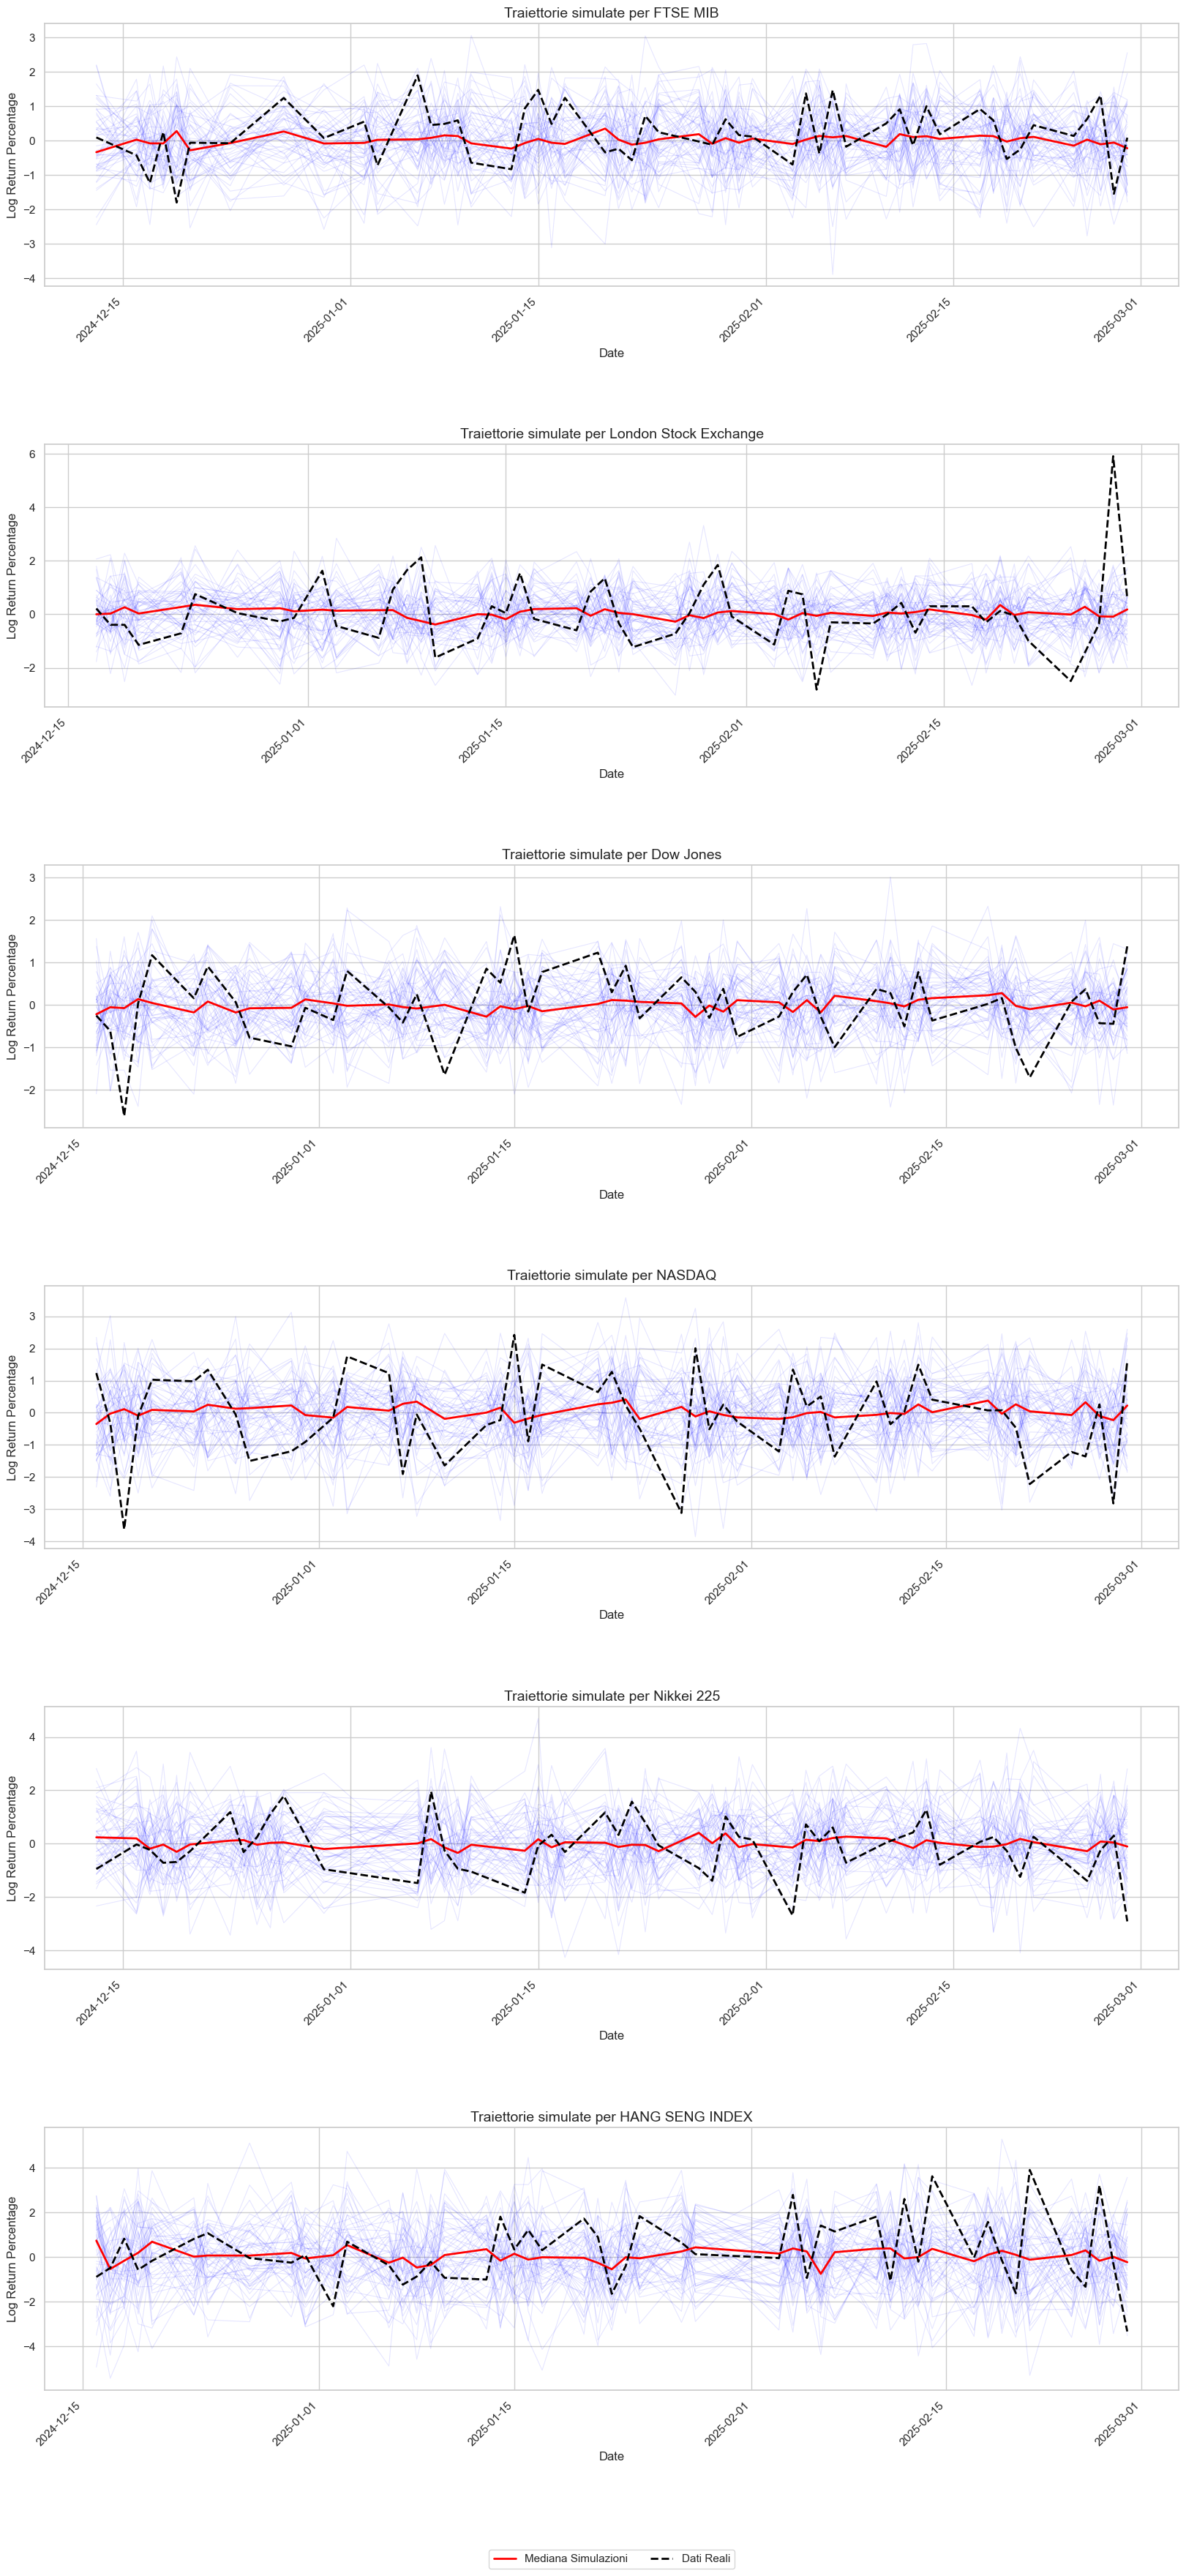

In [133]:
plot_garch_trajectories(trajectories=trajectories, garch_util=garch_util)

In [134]:
def volatility_comparison(garch_util: GarchUtil, conf_levels=None, fig_size=(20,45)):
    
    colors = PlotColors.get_color_list()
    if garch_util is None:
        print('no garch util provied')
        return 
    indexes = garch_util.indexes
    if indexes is None:
        print('not indexes found in garch util')
        return
    
    num_plots = len(indexes)
    fig, axs = plt.subplots(num_plots, 1, figsize=(20, 7 * num_plots), gridspec_kw={'hspace': 0.6})
    i = 0
    trains = garch_util.trains
    for index in indexes:
        j=0
        first = True
        IndexMeta.GARCH_CONDITIONAL_VOLATILITY
        sns.lineplot(x=trains[index.i_name].index, y=trains[index.i_name][IndexMeta.LOG_RETURN_PERCENTAGE], ax=axs[i], color=colors[0],
                     label=f'{index.i_name} {IndexMeta.LOG_RETURN_PERCENTAGE}')
        sns.lineplot(x=index.model['fGARCH[GARCH(1,1)]']['Garch Conditional Volatility'].index,
                     y=index.model['fGARCH[GARCH(1,1)]']['Garch Conditional Volatility'][IndexMeta.GARCH_CONDITIONAL_VOLATILITY],
                     ax=axs[i], color=colors[1], label=f'{index.i_name} {IndexMeta.GARCH_CONDITIONAL_VOLATILITY}', linestyle="dashed")
        axs[i].set_title(label=f'{index.i_name} Volatility and {IndexMeta.LOG_RETURN_PERCENTAGE}')        
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
        axs[i].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=3, frameon=True)
        
        
        i += 1
    plt.xticks(rotation=45)
    plt.show()

### Confronto della Volatilità

Questa funzione si occupa di generare dei grafici comparativi per visualizzare l'andamento nel tempo dei rendimenti logaritmici e della volatilità condizionale stimata per ciascun indice finanziario. Utilizzando i dati presenti nell'oggetto GarchUtil, la funzione crea una serie di sottotrame (una per ogni indice) in cui viene tracciata una linea per i rendimenti e un'altra per la volatilità derivata dal modello fGARCH (GARCH(1,1)). Il grafico risultante, completo di titoli, etichette e legende, consente di analizzare e confrontare visivamente l'evoluzione dei due indicatori nel tempo, evidenziando eventuali dinamiche e differenze tra i vari mercati.


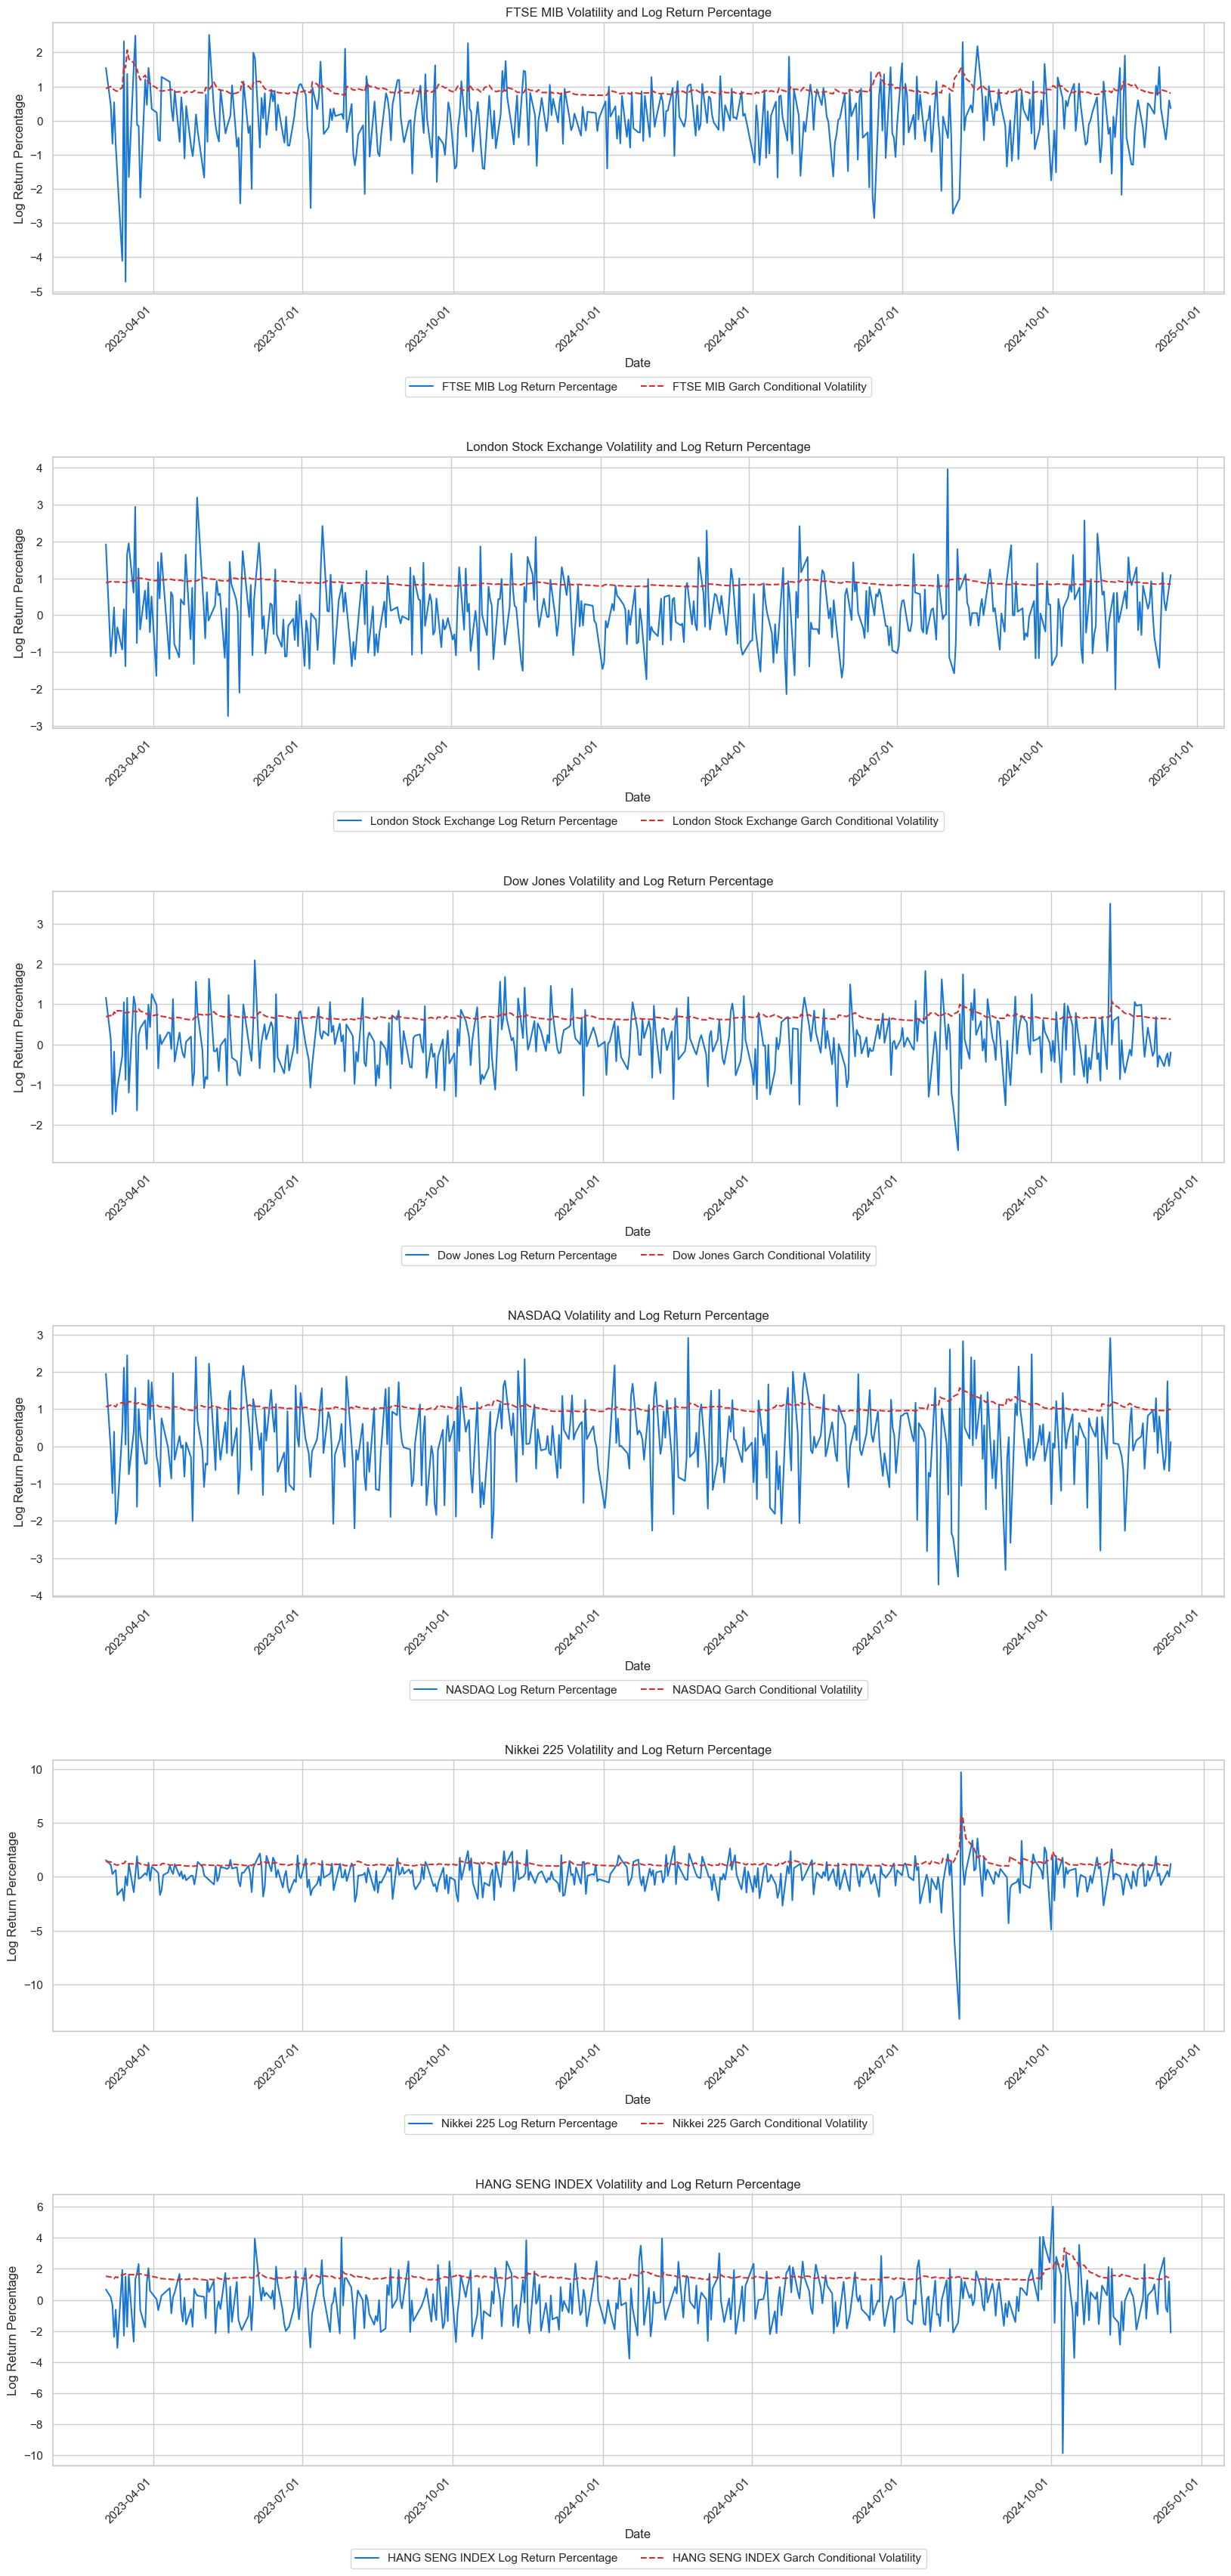

In [135]:
volatility_comparison(garch_util)

### Valutazione degli Intervalli di Confidenza sui Rendimenti Futuri

In questo contesto si mira a verificare l'accuratezza delle previsioni della volatilità, utilizzando intervalli di confidenza per i rendimenti futuri del test set. Per ogni livello di confidenza (ad esempio, 80%, 90%, 95%), vengono definiti dei limiti superiori e inferiori attorno alla stima della volatilità. Questi limiti indicano l'intervallo entro cui ci si aspetta che i rendimenti futuri ricadano con la probabilità specificata.

L'analisi consiste nel controllare quanti dei rendimenti osservati nel test set rientrano in ciascuno di questi intervalli di confidenza. Il risultato viene poi sintetizzato in una tabella, che mostra la percentuale di punti "catturati" dai vari intervalli. Questo approccio permette di valutare la capacità predittiva del modello in termini di accuratezza degli intervalli e di identificare eventuali discrepanze tra le previsioni e i dati reali.


In [222]:
def get_confidence_intervals(indexes=None, conf_levels=None):
    if indexes is None:
        return pd.DataFrame()
    if conf_levels is None:
        conf_levels = [0.8, 0.85, 0.9, 0.95]

    ks = [norm.ppf(1 - (1 - conf) / 2) for conf in conf_levels]
    results = {}

    for index in indexes:
        results[index.i_name] = {}
        actual_returns = index.daily_info[IndexMeta.LOG_RETURN_PERCENTAGE].reindex(index.forecast.index).dropna()

        for k, conf_level in zip(ks, conf_levels):
            upper_band = k * index.forecast[IndexMeta.GARCH_FORECAST_SIGMA]
            lower_band = -k * index.forecast[IndexMeta.GARCH_FORECAST_SIGMA]

            inside_band = ((actual_returns >= lower_band) & (actual_returns <= upper_band)).sum()
            total_points = len(actual_returns)
            percentage_inside = round((inside_band / total_points) * 100, 2) if total_points > 0 else 0.00

            results[index.i_name][f"{int(conf_level * 100)}%"] = f"{percentage_inside:.2f}%"

    return pd.DataFrame.from_dict(results, orient='index')

def plot_prevision_band(indexes=None, conf_levels=None, fig_size=(20,45)):
    colors = PlotColors.get_color_list()
    if indexes is None:
        return
    if conf_levels is None:
        conf_levels = [0.8, 0.9, 0.95]
        #conf_levels.sort(reverse=True)
    
    fig, axs = plt.subplots(len(indexes), 1, figsize=fig_size,  gridspec_kw={'hspace': 0.8})
    
    
    ks = []
    for conf_level in conf_levels:
        alpha = 1 - conf_level
        ks.append(norm.ppf(1 - alpha / 2))
    
    i = 0
    for index in indexes:
        j=0
        first = True
        sns.lineplot(x=index.daily_info.index, y=index.daily_info[IndexMeta.LOG_RETURN_PERCENTAGE], ax=axs[i], color=colors[0],
                     label=f'{index.i_name} {IndexMeta.LOG_RETURN_PERCENTAGE}')
        axs[i].set_title(label=f'{index.i_name} prediction bands')
        for k in ks:
            upper_band = (k * pd.DataFrame(index.forecast[IndexMeta.GARCH_FORECAST_SIGMA]))
            lower_band = (-k * pd.DataFrame(index.forecast[IndexMeta.GARCH_FORECAST_SIGMA]))
            if first:
                first = False
                axs[i].axvline(x=upper_band.index[0], linestyle="dashed", color="black", label="test set boundary")
            axs[i].fill_between(index.forecast.index,upper_band[IndexMeta.GARCH_FORECAST_SIGMA],
                                lower_band[IndexMeta.GARCH_FORECAST_SIGMA], alpha=0.3,color=colors[j+1])
            sns.lineplot(x=index.forecast.index, y=upper_band[IndexMeta.GARCH_FORECAST_SIGMA], linestyle="dashed", ax=axs[i],  color=colors[j+1],
                         label=f'UpperBound {int(conf_levels[j] * 100)}%')
            sns.lineplot(x=index.forecast.index, y= lower_band[IndexMeta.GARCH_FORECAST_SIGMA], linestyle="dashed", ax=axs[i],  color=colors[j+1],
                         label=f'LowerBound {int(conf_levels[j] * 100)}%')
            j +=1
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
        axs[i].legend(loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3, frameon=True)
        
        
        
        i += 1
    #plt.xticks(rotation=45)
    plt.show()
    



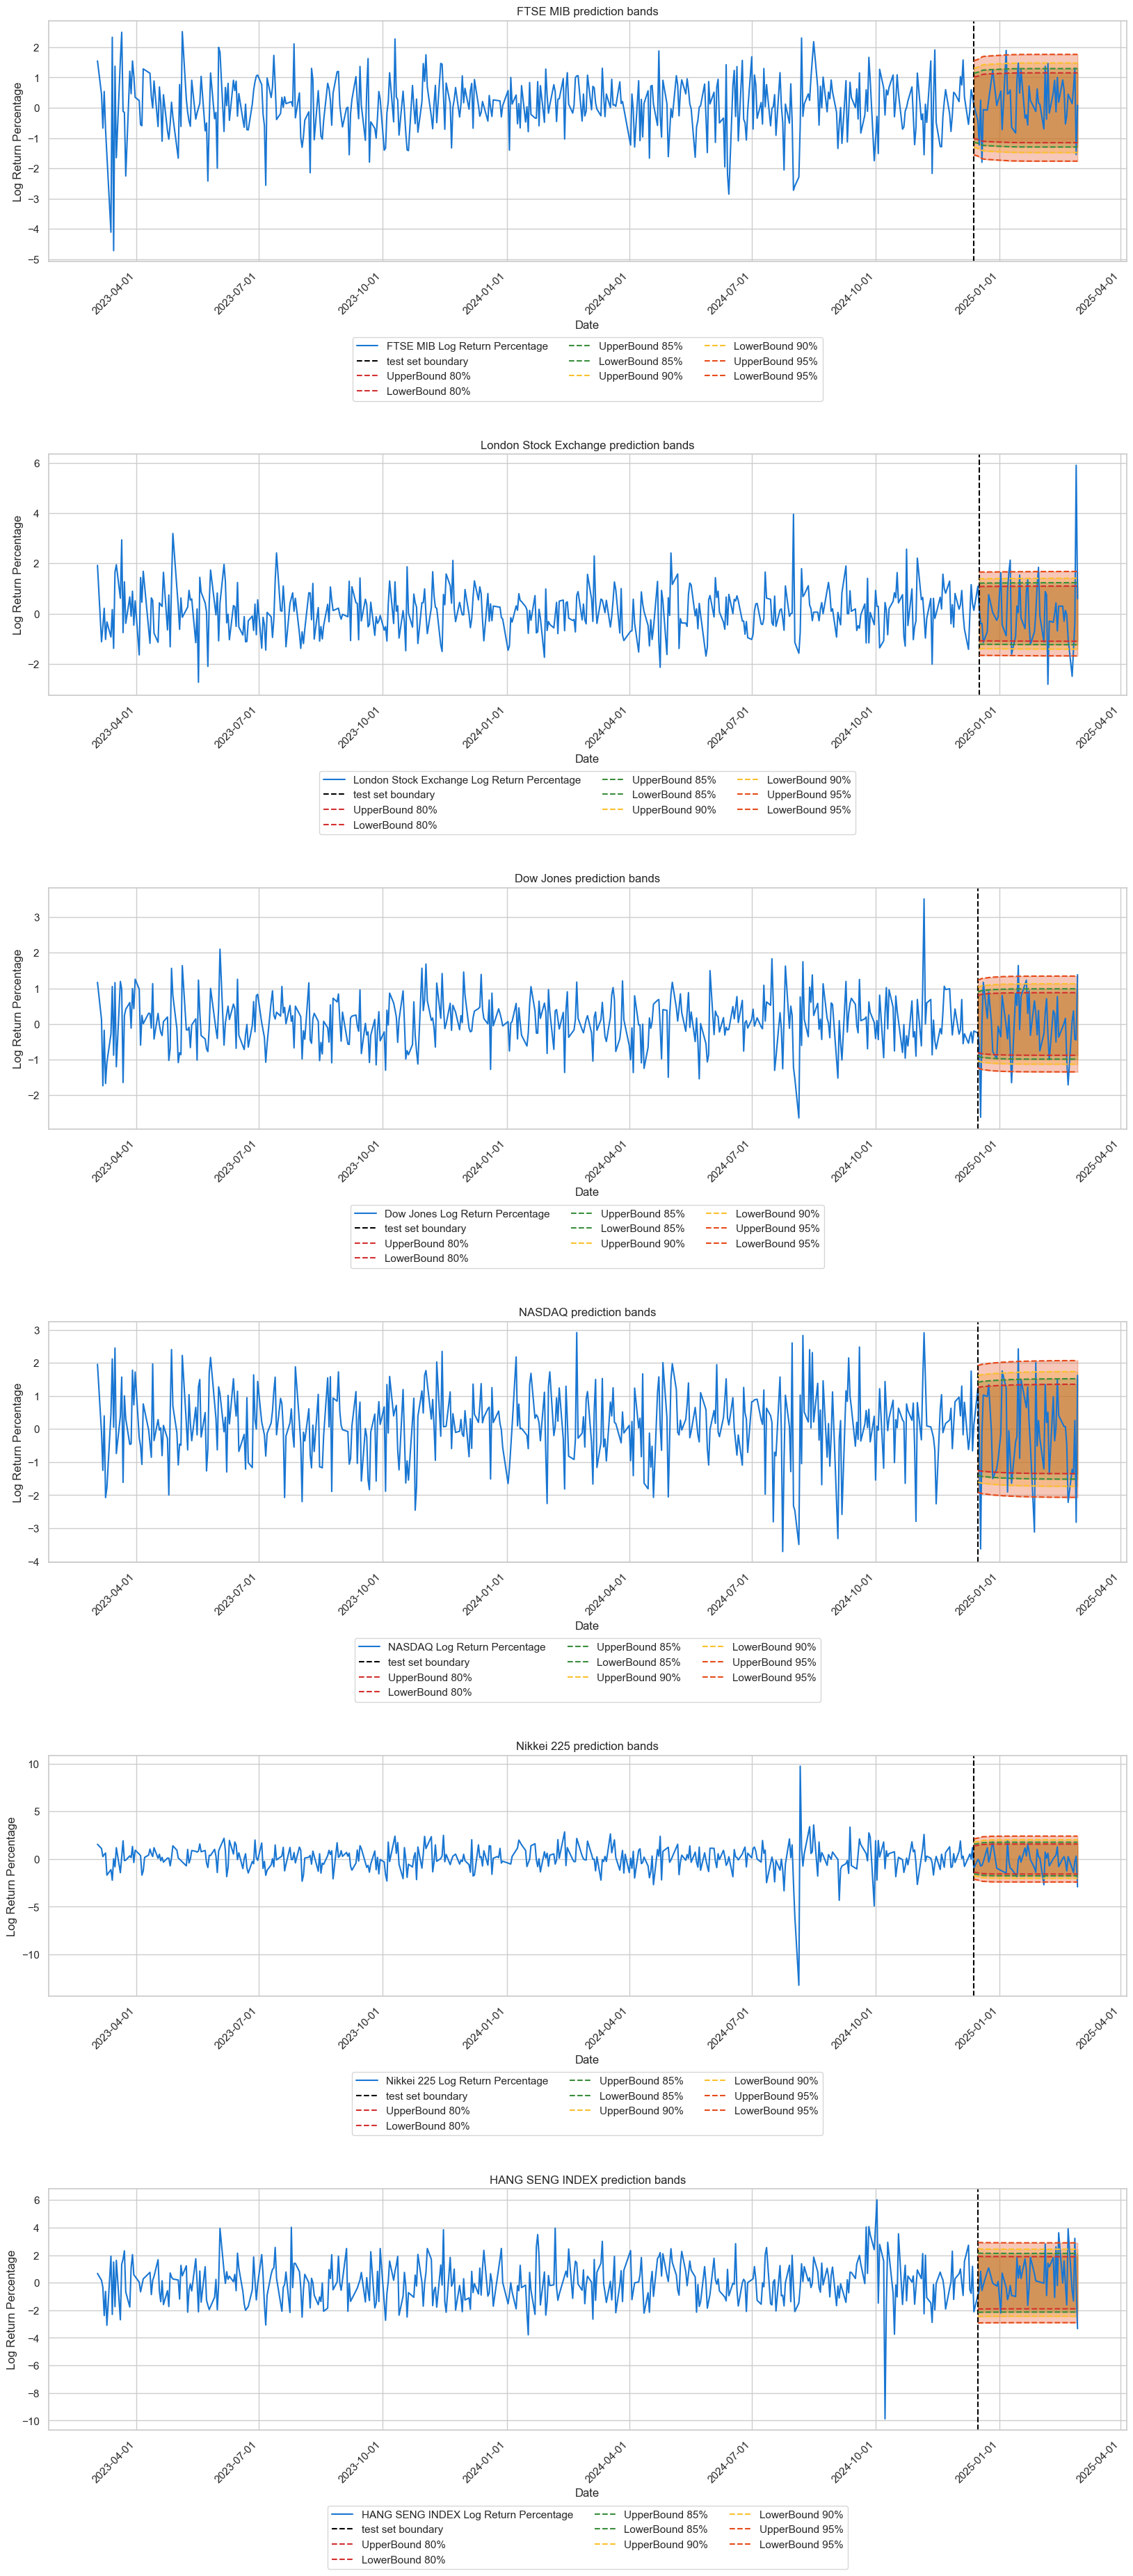

In [223]:
df = plot_prevision_band(injector.indexes)

In [220]:
display(HTML(get_confidence_intervals(injector.indexes).to_html(classes='styled-table-2', escape=False)))

### 4) Metriche di Accuratezza
Per valutare il modello usato, consideriamo le seguenti metriche di accuratezza:
* Scale-Dependent Metrics <br>
    * $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $ <br>
    Indica l'errore medio assoluto tra le previsioni e i valori reali. Un valore basso è preferibile, poiché indica una buona adattabilità del modello ai dati. <br> <br>
    * $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $ <br>
    Misura la deviazione quadratica media tra le previsioni e i valori reali. Si eleva al quadrato gli errori, enfatizzando gli errori più grandi. È sensibile agli outlier. Un MSE più basso è migliore, indicando una migliore precisione.

* Scale Free Metrics <br>
    * $\text{MASE} = \frac{MAE}{\frac{1}{m-1} \sum_{j=2}^{m} |y_j - y_{j-1}|} $ <br>
    Valuta la capacità predittiva del modello rispetto a un modello *naïve* dove le previsioni sono basate sul valore precedente. Un valore inferiore a 1 indica che il modello è migliore del modello *naïve*. <br> <br>
    * $\text{RMSSE} = \sqrt{\frac{MSE}{\frac{1}{m-1} \sum_{j=2}^{m} (y_j - y_{j-1})^2}} $ <br>
    È una versione scalata di MSE, che considera anche il confronto con un modello di benchmark (ad esempio, il modello naïve). Un valore inferiore a 1 indica una migliore performance rispetto al modello di riferimento.

In [138]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mase(y_true, y_pred):
    mae_val = mae(y_true, y_pred)
    naive_mae = np.mean(np.abs(np.diff(y_true)))  
    return mae_val / naive_mae if naive_mae != 0 else np.nan  

def rmsse(y_true, y_pred):
    mse_val = mse(y_true, y_pred)
    naive_mse = np.mean(np.diff(y_true) ** 2)  
    return np.sqrt(mse_val / naive_mse) if naive_mse != 0 else np.nan  

def make_accuracy_dict() -> dict:
    accuracy_dict = {}
    for index in garch_util.indexes:
        MSE = mse(index.realized_volatility.tail(len(index.forecast))[IndexMeta.REALIZED_VOLATILITY],
                  (index.forecast[IndexMeta.GARCH_FORECAST_SIGMA])**2)
        MAE = mae(index.realized_volatility.tail(len(index.forecast))[IndexMeta.REALIZED_VOLATILITY],
                  (index.forecast[IndexMeta.GARCH_FORECAST_SIGMA])**2)
        MASE = mase(index.realized_volatility.tail(len(index.forecast))[IndexMeta.REALIZED_VOLATILITY],
                  (index.forecast[IndexMeta.GARCH_FORECAST_SIGMA])**2)
        RMSSE = rmsse(index.realized_volatility.tail(len(index.forecast))[IndexMeta.REALIZED_VOLATILITY],
                  (index.forecast[IndexMeta.GARCH_FORECAST_SIGMA])**2)
        accuracy_dict[index.i_name] = {
            'MAE' : MAE,
            'MSE' : MSE,
            'MASE': MASE,
            'RMSSE': RMSSE
        }
    return pd.DataFrame.from_dict(accuracy_dict, orient='index')

In [221]:
display(HTML(make_accuracy_dict().to_html(classes='styled-table-2', escape=False)))

## GARCH MULTIDIMENSIONALE

I modelli GARCH multidimensionali rappresentano un'estensione dei modelli univariati, progettati per catturare non solo la volatilità condizionata di una singola serie, ma anche le interdipendenze tra più serie temporali. Questi modelli sono particolarmente utili in ambito finanziario per analizzare la dinamica congiunta di asset, consentendo di modellare la matrice di covarianza condizionata e, quindi, di prevedere in maniera dinamica sia le varianze individuali sia le correlazioni tra di esse.

### Motivazioni e Obiettivi

- **Dinamica Congiunta:** I modelli multidimensionali permettono di descrivere come la volatilità di ciascun asset interagisca con quella degli altri, offrendo una visione più completa dei rischi condivisi.
- **Gestione del Rischio e Ottimizzazione del Portafoglio:** La stima dinamica della matrice di covarianza è fondamentale per valutare la correlazione tra asset e per costruire portafogli efficienti.
- **Garantire la Positività:** Questi modelli assicurano che la matrice di covarianza condizionata sia definita positiva, condizione essenziale per la coerenza delle previsioni di rischio.

### DCC-GARCH

### Formulazione del DCC-GARCH

Il modello DCC-GARCH si articola in due fasi: la modellizzazione univariata della volatilità per ogni serie e la dinamica condizionale delle correlazioni tra le serie.

#### 1. Modellizzazione Univariata

Per ogni serie \(i\), si assume un modello GARCH univariato, ad esempio di tipo GARCH(1,1):

$r_{i,t} = \mu_i + \epsilon_{i,t}, \quad \epsilon_{i,t} = \sqrt{h_{i,t}} \, z_{i,t}$

$h_{i,t} = \omega_i + \alpha_i \, \epsilon_{i,t-1}^2 + \beta_i \, h_{i,t-1}$

dove:
- $r_{i,t}$ è il rendimento della serie $i$ al tempo $t$;
- $h_{i,t}$ è la varianza condizionata della serie $i$;
- $z_{i,t}$ sono gli errori standardizzati, assunti generalmente i.i.d. con distribuzione adatta (es. normale o t-Student).

I residui standardizzati sono ottenuti come:

$z_{i,t} = \frac{\epsilon_{i,t}}{\sqrt{h_{i,t}}}$

#### 2. Dinamica Condizionale delle Correlazioni

Una volta ottenuti i residui standardizzati per tutte le serie, si definisce il vettore $z_t = (z_{1,t}, z_{2,t}, \dots, z_{N,t})'$ e si costruisce la matrice di correlazione non normalizzata \(Q_t\) secondo il seguente processo dinamico:

$Q_t = (1 - a - b) \, \bar{Q} + a \, z_{t-1} z_{t-1}' + b \, Q_{t-1}$

dove:
- \(a\) e \(b\) sono parametri che controllano l'impatto degli shock passati e la persistenza della dinamica delle correlazioni;
- $\bar{Q}$ è la matrice di covarianza invariante (o incondizionata) dei residui standardizzati.

Infine, la matrice di correlazione condizionale $R_t$ viene ottenuta normalizzando $Q_t$:

$R_t = \text{diag}(Q_t)^{-1/2} \, Q_t \, \text{diag}(Q_t)^{-1/2}$

Questa normalizzazione assicura che la diagonale di $R_t$ sia composta da 1, rendendo $R_t$ una vera matrice di correlazione condizionata.




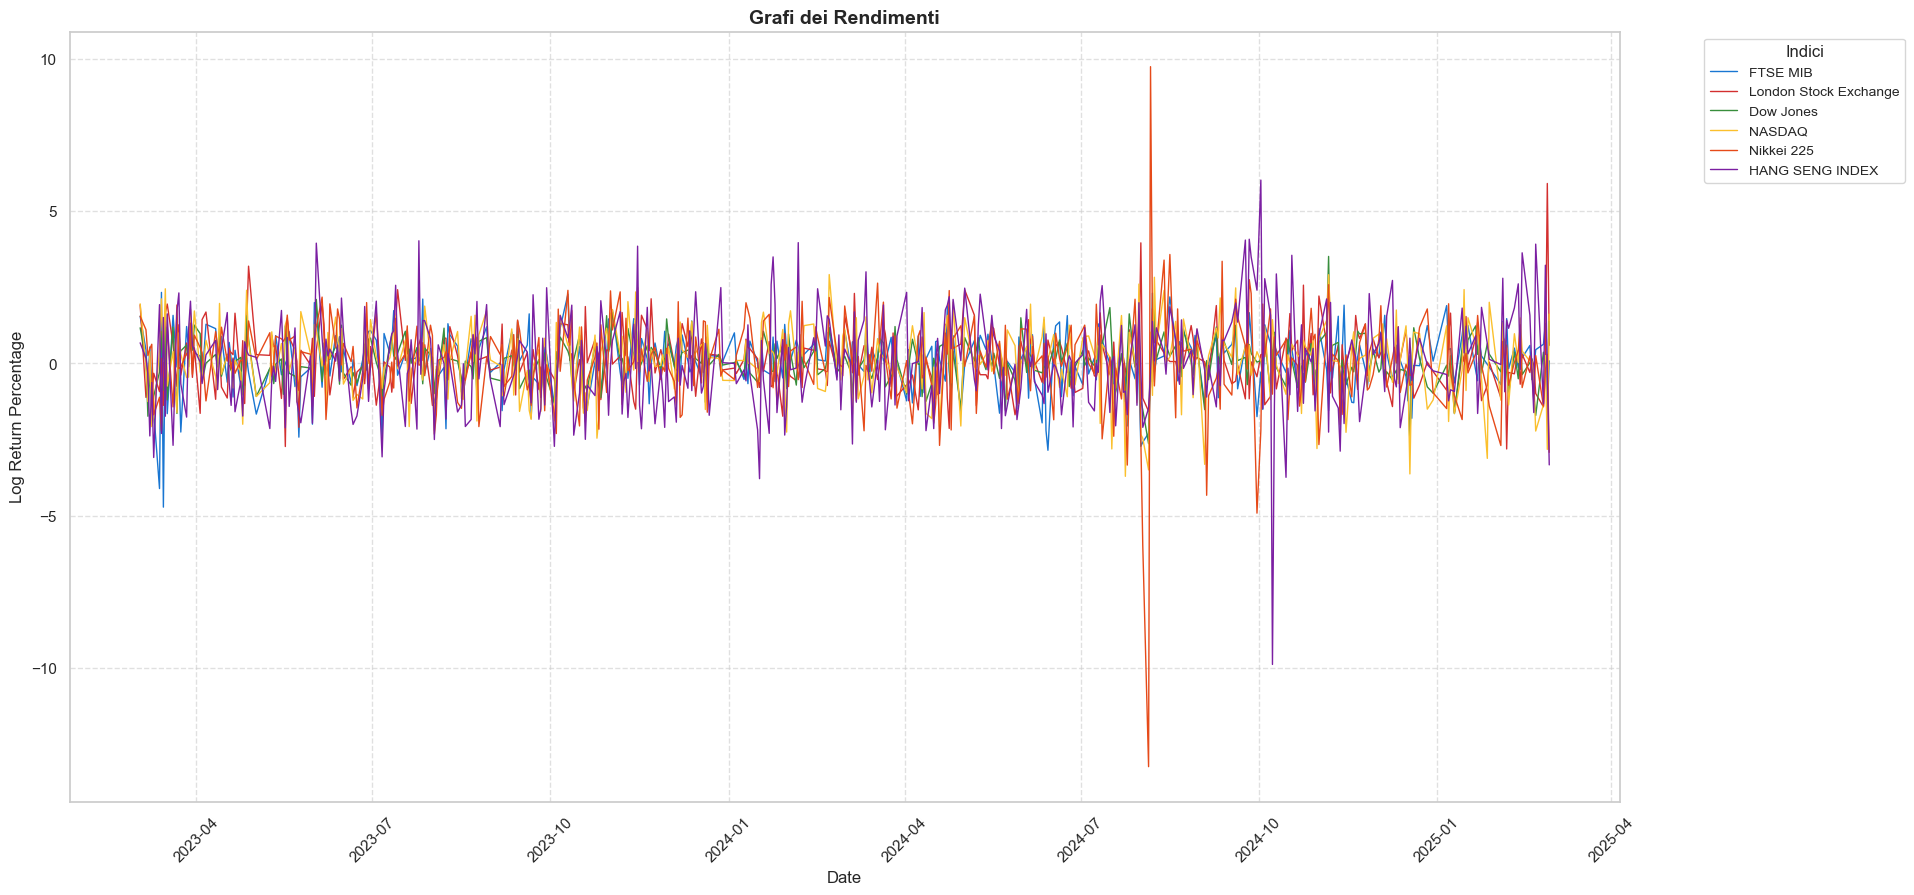

In [241]:
def plot_dataframe_lines(df, title='Grafi dei Rendimenti', figsize=(20, 10), colors=None):
    plt.figure(figsize=figsize)
    
    if colors is None:
        colors = PlotColors.get_color_list()
        
    for i, column in enumerate(df.columns):
        sns.lineplot(x=df.index, y=df[column], label=column, color=colors[i], linewidth=1)

    # Miglioramenti estetici
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(IndexMeta.LOG_RETURN_PERCENTAGE, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Indici", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


plot_dataframe_lines(injector.get_multi_index())




In [235]:
AVAILABLE_RM_GARCH = {
    "DCC": "get_best_dcc_garch",
    "GO" : "get_best_go_garch",
    "CDCC": "get_best_cdcc_garch"
}

def rm_garch_in_R(rm_model=AVAILABLE_RM_GARCH["DCC"]):
    
    ret = []
    forecast_horizon = 5
    pandas2ri.activate()
    ro.r('Sys.getlocale()')
    ro.r('Sys.setlocale("LC_ALL", "en_US.UTF-8")')
    ro.r('source("R/RMGarch_model.R")')
    df_log_ret = injector.get_multi_index()
    model_r_func = ro.r[f'{rm_model}']
    r_rets = ro.conversion.py2rpy(df_log_ret)
    r_rets = ro.r('as.matrix')(r_rets) 
    r_rmgarch = ro.r(rm_model)
    r_res = r_rmgarch(r_rets, 20)
    r_dccgarch_model = r_res[0]
    r_forecast_cov = r_res[1]
    pandas2ri.deactivate()
    n_cols = df_log_ret.shape[1]
    n_elements = n_cols * n_cols
    n_matrix = len(r_forecast_cov[0]) // n_elements

    cov_matrix = np.zeros((n_cols, n_cols))
    for i in range(n_matrix):
        i_matrix = np.array(r_forecast_cov[0][i * n_elements:(i + 1) * n_elements])
        i_matrix = i_matrix.reshape(n_cols, n_cols)
        cov_matrix += i_matrix

    print("Numero di matrici previste:", n_matrix)
    print("Matrice di covarianza sommata:\n", cov_matrix)
    corr_matrix = np.corrcoef(cov_matrix)
    return corr_matrix
    
#rm_garch_in_R(indexes=[], rm_model=AVAILABLE_RM_GARCH['DCC'])
#rm_garch_in_R(indexes=[], rm_model=AVAILABLE_RM_GARCH['GO'])
#rm_garch_in_R(indexes=[], rm_model=AVAILABLE_RM_GARCH['CDCC'])

### Interpretazione della Heatmap della Matrice di Correlazione

La heatmap della matrice di correlazione offre una rappresentazione visiva immediata delle relazioni tra le variabili (o asset). Ecco come interpretarla:

- **Colori e Intensità:**  
  I colori rappresentano il grado e la direzione della correlazione. Solitamente, tonalità più calde (ad es. rosso) indicano correlazioni positive elevate, mentre tonalità più fredde (ad es. blu) evidenziano correlazioni negative. Le tonalità intermedie indicano correlazioni deboli o prossime allo zero.

- **Simmetria della Matrice:**  
  La matrice è simmetrica, in quanto la correlazione tra la variabile A e B è la stessa di quella tra B e A. La diagonale principale mostra sempre il valore 1, rappresentando la correlazione di ogni variabile con se stessa.

- **Rilevamento di Pattern e Cluster:**  
  Zone con colori simili suggeriscono che alcuni asset si comportano in maniera molto affine, evidenziando possibili raggruppamenti o cluster di variabili correlate. Queste informazioni possono essere utili per la diversificazione del portafoglio, poiché asset con bassa correlazione tendono a ridurre il rischio complessivo.

- **Applicazioni Pratiche:**  
  La heatmap aiuta a individuare rapidamente le relazioni più forti e quelle deboli, facilitando la gestione del rischio e l'ottimizzazione del portafoglio. Essa può evidenziare correlazioni sistemiche e fornire spunti su come strutturare strategie di copertura.


Numero di matrici previste: 20
Matrice di covarianza sommata:
 [[16.44964291  0.90249448  4.55108944  6.3540502   5.56553738  7.08065123]
 [ 0.90249448 20.46124212  2.11630192  2.52531109  2.46510033 -0.29079875]
 [ 4.55108944  2.11630192 10.817237   12.29615852  2.65794382  1.784158  ]
 [ 6.3540502   2.52531109 12.29615852 34.17282394  4.92425325  5.64377149]
 [ 5.56553738  2.46510033  2.65794382  4.92425325 35.56386152 11.51553752]
 [ 7.08065123 -0.29079875  1.784158    5.64377149 11.51553752 58.95582471]]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'FTSE MIB'),
  Text(1.5, 0, 'London Stock Exchange'),
  Text(2.5, 0, 'Dow Jones'),
  Text(3.5, 0, 'NASDAQ'),
  Text(4.5, 0, 'Nikkei 225'),
  Text(5.5, 0, 'HANG SENG INDEX')])

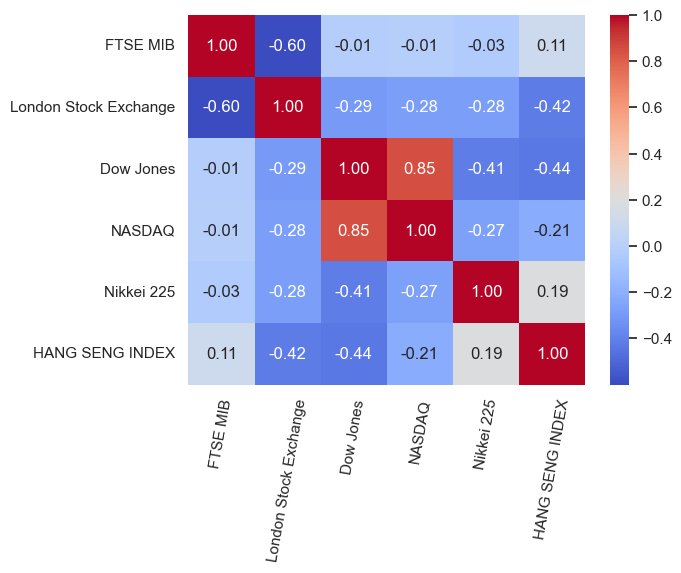

In [184]:

labels = []
for index in injector.indexes:
    labels.append(index.i_name)
sns.heatmap(rm_garch_in_R(AVAILABLE_RM_GARCH['DCC']), annot=True, cmap='coolwarm', fmt=".2f", cbar=True, 
            xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=80)


In [178]:
corr_matrix

array([[ 1.        , -0.59967263, -0.02067463, -0.01196306, -0.02702816,
         0.11300399],
       [-0.59967263,  1.        , -0.29310021, -0.28367402, -0.27295122,
        -0.42072104],
       [-0.02067463, -0.29310021,  1.        ,  0.85119067, -0.41943754,
        -0.44061935],
       [-0.01196306, -0.28367402,  0.85119067,  1.        , -0.27554079,
        -0.21620197],
       [-0.02702816, -0.27295122, -0.41943754, -0.27554079,  1.        ,
         0.19706149],
       [ 0.11300399, -0.42072104, -0.44061935, -0.21620197,  0.19706149,
         1.        ]])

In [144]:
date_range = pd.date_range(start="2023-01-01", end=pd.Timestamp.today(), freq="D")
pd.DataFrame({
    "Prezzo": np.random.randn(len(date_range)) * 10 + 100,
    "ADJUSTED_CLOSE": np.random.randn(len(date_range)) * 5 + 50,
}, index=date_range)

Prezzo  ADJUSTED_CLOSE
2023-01-01  105.639592       53.449424
2023-01-02  101.091572       53.344050
2023-01-03  106.698769       61.868946
2023-01-04   90.935985       53.358099
2023-01-05   87.530427       50.745018
...                ...             ...
2025-02-25   96.695413       51.102456
2025-02-26  130.216513       60.273073
2025-02-27   82.663269       51.844336
2025-02-28   91.354063       44.664902
2025-03-01   89.192060       52.621055

[791 rows x 2 columns]

In [ ]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

date_range = pd.date_range(start="2023-01-01", end=pd.Timestamp.today(), freq="D")

np.random.seed(42)
df = pd.DataFrame({
    "Prezzo": np.random.randn(len(date_range)) * 10 + 100,
    "ADJUSTED_CLOSE": np.random.randn(len(date_range)) * 5 + 50,
}, index=date_range)

df_log_ret = np.log(df / df.shift(1)) * 100
df_log_ret = injector.get_multi_index()

if df_log_ret.shape[1] == 1:
    df_log_ret['log_ret_2'] = df_log_ret.iloc[:, 0]


pandas2ri.activate()
r_rets = ro.conversion.py2rpy(df_log_ret)
r_rets = ro.r('as.matrix')(r_rets) 

r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        r_rets <- as.matrix(r_rets)
                        n <- dim(r_rets)[2]

                        if (n < 2) stop("Errore: DCC-GARCH richiede almeno due serie temporali.")  

                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvlaplace")
                        
                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        list(dcc_fit, forecasts@mforecast$H)
                }
                """

r_dccgarch = ro.r(r_dccgarch_code)
r_res = r_dccgarch(r_rets, 20) 
pandas2ri.deactivate()

r_dccgarch_model = r_res[0]
r_forecast_cov = r_res[1]

n_cols = df_log_ret.shape[1]
n_elements = n_cols * n_cols
n_matrix = len(r_forecast_cov[0]) // n_elements

cov_matrix = np.zeros((n_cols, n_cols))
for i in range(n_matrix):
    i_matrix = np.array(r_forecast_cov[0][i * n_elements:(i + 1) * n_elements])
    i_matrix = i_matrix.reshape(n_cols, n_cols)
    cov_matrix += i_matrix

print("Numero di matrici previste:", n_matrix)
print("Matrice di covarianza sommata:\n", cov_matrix)

In [17]:

%%capture
!jupyter nbconvert --to html --no-input --execute --HTMLExporter.mathjax=True project.ipynb



In [16]:
%%capture
!jupyter nbconvert --to pdf project.ipynb
